In [1]:
%matplotlib inline
import numpy as np
from astropy.table import Table, hstack
import scipy.stats
import dustmaps.bayestar, dustmaps.sfd
import astropy.units as units
from astropy.coordinates import SkyCoord
from matplotlib import rcParams
from scipy.stats import skewnorm
from scipy.optimize import curve_fit
%config IPython.matplotlib.backend = 'retina'
%config InlineBackend.figure_format = 'retina'
rcParams["font.family"] = "sans-serif"
rcParams["font.sans-serif"] = ["Computer Modern Sans"]
rcParams["text.usetex"] = True
#rcParams["text.latex.preamble"] = r"\usepackage{cmbright}"
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%cd ..
from starlight.models import SimpleHRDModel
from starlight.models_cy import *
# Some nice colors
cols = [(0.65098041296005249, 0.80784314870834351, 0.89019608497619629),
 (0.12572087695201239, 0.47323337360924367, 0.707327968232772),
 (0.68899655751153521, 0.8681737867056154, 0.54376011946622071),
 (0.21171857311445125, 0.63326415104024547, 0.1812226118410335),
 (0.98320646005518297, 0.5980161709820524, 0.59423301088459368)]
%cd Starlight

/Users/bl/Dropbox/repos/Starlight
/Users/bl/Dropbox/repos/Starlight/starlight


In [2]:
data_tgas = Table.read('../tgas-source.fits')
#data_2mass = Table.read('/Users/bl/Downloads/tgas-matched-2mass-cut.fits')
#data_2mass.rename_column('matched', 'matched_2mass')
#data_wise = Table.read('/Users/bl/Downloads/tgas-matched-wise-cut.fits')
#data_wise.rename_column('matched', 'matched_wise')
data_apass = Table.read('../tgas-matched-apass-dr9.fits')
data_apass.rename_column('matched', 'matched_apass')
data_apass.rename_column('matchdist', 'matchdist_apass')
#data_join = hstack((data_apass, data_wise, data_2mass,
#                    data_tgas['parallax', 'parallax_error']))
data_join = hstack((data_apass, data_tgas['l', 'b', 'parallax', 'parallax_error', 'phot_g_mean_mag']))
#data_tgas['parallax_error'] = np.sqrt(data_tgas['parallax_error']**2 + 0.3**2)
len(data_join), data_join.colnames

(2057050,
 ['ra',
  'dec',
  'bmag',
  'vmag',
  'gmag',
  'rmag',
  'imag',
  'e_bmag',
  'e_vmag',
  'e_gmag',
  'e_rmag',
  'e_imag',
  'matched_apass',
  'matchdist_apass',
  'l',
  'b',
  'parallax',
  'parallax_error',
  'phot_g_mean_mag'])

In [3]:
ind = np.repeat(True, len(data_join))
ind &= data_join['matched_apass']
ind &= np.isfinite(data_join['vmag'])
ind &= np.isfinite(data_join['bmag'])
ind &= np.isfinite(data_join['parallax'])
ind &= np.isfinite(data_join['e_vmag'])
ind &= np.isfinite(data_join['e_bmag'])
ind &= np.isfinite(data_join['parallax_error'])
ind &= data_join['e_vmag'] > 0
ind &= data_join['e_bmag'] > 0
ind &= data_join['parallax_error'] > 0
ind &= (data_join['parallax'] / data_join['parallax_error'] > 1/1) # Main cut
print('Number of objects=', ind.sum())
df = data_join[ind].to_pandas()
df.describe()

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater
/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


Number of objects= 1464782


,ra,dec,bmag,vmag,gmag,rmag,imag,e_bmag,e_vmag,e_gmag,e_rmag,e_imag,matchdist_apass,l,b,parallax,parallax_error,phot_g_mean_mag
count,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.453461e+06,1.427111e+06,1.372168e+06,1.464782e+06,1.464782e+06,1.453461e+06,1.427111e+06,1.372168e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06,1.464782e+06
mean,1.816695e+02,-3.101188e+00,1.206702e+01,1.133427e+01,1.169036e+01,1.116519e+01,1.103557e+01,5.475333e-02,4.379613e-02,6.267670e-02,4.169821e-02,6.969434e-02,5.392305e-05,1.892242e+02,-1.690342e+00,2.425910e+00,3.797061e-01,1.106769e+01
std,1.013317e+02,4.292381e+01,8.131927e-01,7.759872e-01,7.491655e-01,7.886966e-01,8.394411e-01,8.187632e-02,6.294040e-02,1.125786e-01,6.501273e-02,1.347890e-01,4.968288e-05,1.010618e+02,2.958069e+01,2.204461e+00,1.650950e-01,8.320954e-01
min,4.480000e-04,-8.867937e+01,6.032000e+00,5.828000e+00,6.290000e+00,5.738000e+00,4.594000e+00,1.000000e-03,1.000000e-03,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,8.787958e-04,-8.987968e+01,2.167810e-01,2.048801e-01,4.649394e+00
25%,9.941414e+01,-4.031799e+01,1.156100e+01,1.081200e+01,1.118900e+01,1.063200e+01,1.050300e+01,2.100000e-02,2.000000e-02,1.800000e-02,1.900000e-02,2.400000e-02,2.141253e-05,9.982691e+01,-1.845621e+01,1.137216e+00,2.669441e-01,1.051163e+01
50%,1.718249e+02,-5.352760e+00,1.217600e+01,1.142600e+01,1.177600e+01,1.124100e+01,1.110800e+01,3.300000e-02,3.300000e-02,3.300000e-02,3.200000e-02,4.300000e-02,3.742997e-05,1.984313e+02,-1.570938e+00,1.841779e+00,3.193105e-01,1.116613e+01
75%,2.752525e+02,3.443952e+01,1.266700e+01,1.191700e+01,1.224700e+01,1.175300e+01,1.164700e+01,5.600000e-02,5.300000e-02,6.400000e-02,5.100000e-02,7.000000e-02,6.725873e-05,2.774967e+02,1.535374e+01,2.993496e+00,4.281026e-01,1.168366e+01
max,3.599999e+02,8.867352e+01,1.728600e+01,1.539800e+01,1.830900e+01,1.746200e+01,1.773700e+01,4.936000e+00,5.191000e+00,6.850000e+00,5.577000e+00,5.884000e+00,2.777731e-04,3.599988e+02,8.989966e+01,1.205942e+02,9.999978e-01,1.569592e+01


In [4]:
bayestar = dustmaps.bayestar.BayestarQuery(max_samples=2)
sfd = dustmaps.sfd.SFDQuery()

In [5]:
nobj = int(1e4) # len(df) #
sel = np.random.choice(len(df), nobj, replace=False)

varpi = df[['parallax']].values[sel, :].ravel().astype(np.double)
varpi_err = df[['parallax_error']].values[sel, :].ravel().astype(np.double)

ls = df[['l']].values[sel, :].ravel().astype(np.double)
bs = df[['b']].values[sel, :].ravel().astype(np.double)
distances = (1/varpi)
coords = SkyCoord(ls*units.deg, bs*units.deg, distance=distances*units.pc, frame='galactic')
ras, decs = coords.icrs.ra.rad, coords.icrs.dec.rad
ebv = bayestar(coords, mode='median')
ebv2 = sfd(coords)
ind2 = ~np.isfinite(ebv)
ebv[ind2] = 0 #ebv2[ind2]

B_RedCoeff = 3.626
V_RedCoeff = 2.742

obsmags = df[['vmag']].values[sel, :].astype(np.double).ravel() - ebv * V_RedCoeff
obsmags_err = df[['e_vmag']].values[sel, :].astype(np.double).ravel()

ncols = 1
obscolors = df[['bmag']].values[sel, :].astype(np.double) - ebv[:, None] * B_RedCoeff - obsmags[:, None]
obscolors_err = np.sqrt(df[['e_bmag']].values[sel, :].astype(np.double)**2 + obsmags_err[:, None]**2)

obsabsmag = obsmags + 5*np.log10(varpi) - 10
obsabsmagG = df[['phot_g_mean_mag']].values[sel, :].astype(np.double).ravel() + 5*np.log10(varpi) - 10
obsabsmag.min(), obsabsmag.max(), obscolors.min(), obscolors.max()

/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 3239 results
  RuntimeWarning)


(-3.5021733605962897,
 9.8290147943838946,
 -0.41634191013872623,
 2.2669631675526034)

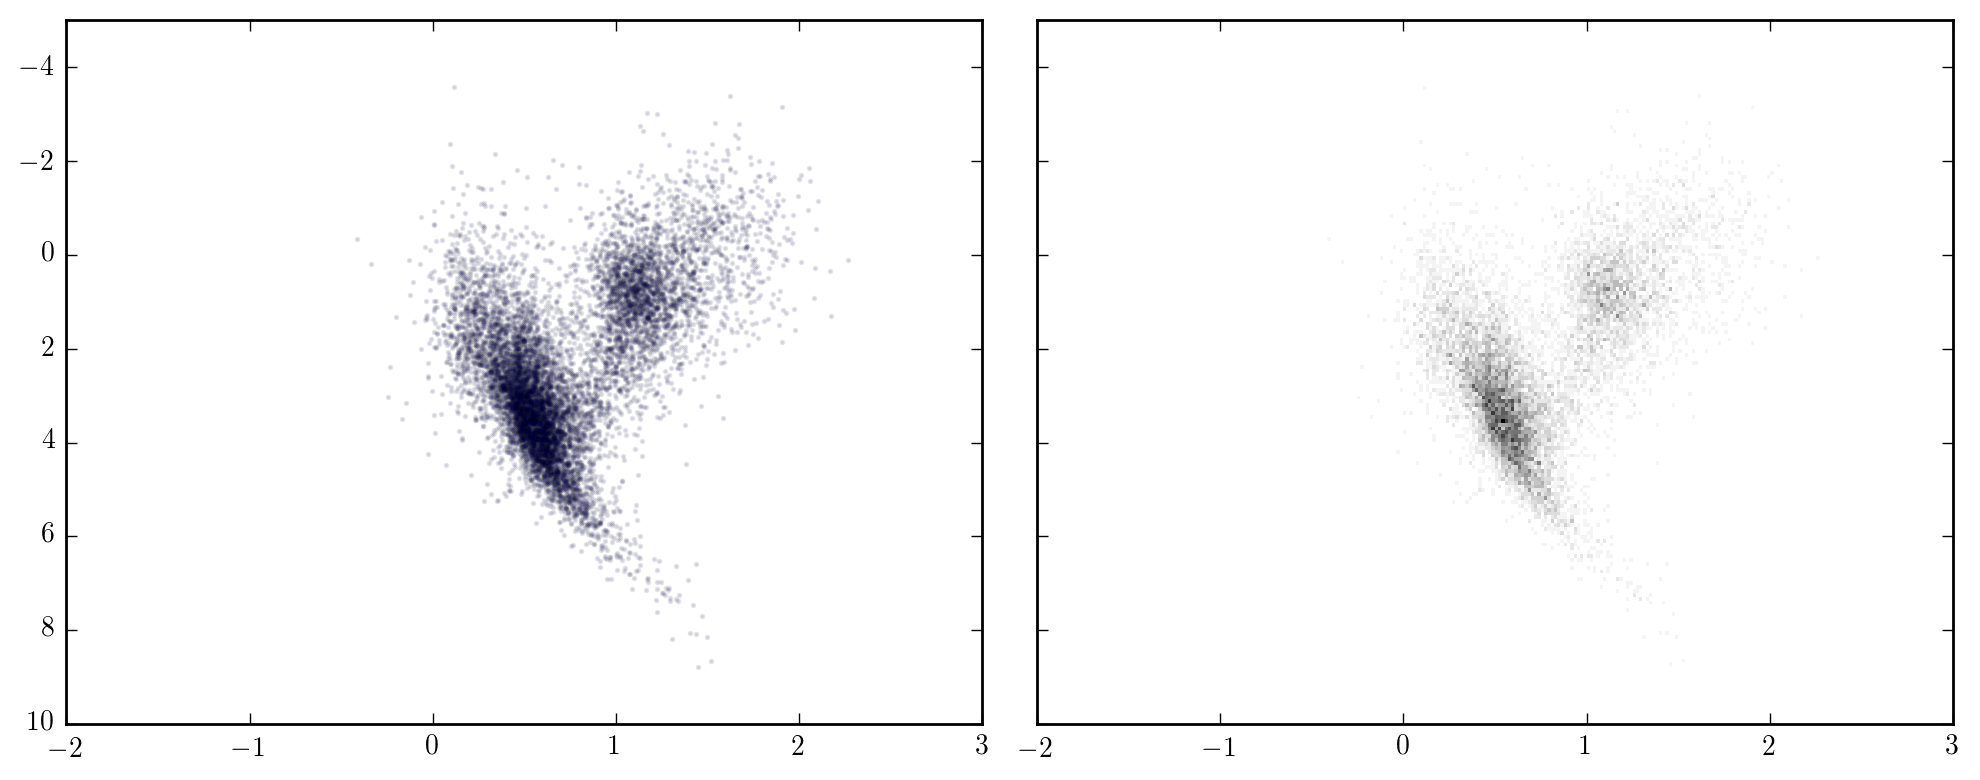

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
ind2 = obscolors[:, 0] > -2
ind2 &= obscolors[:, 0] < 3
ind2 &= np.isfinite(ebv)
axs[0].scatter(obscolors[ind2, 0], obsabsmagG[ind2], s=1, alpha=0.1)
axs[1].hist2d(obscolors[ind2].ravel(), obsabsmagG[ind2], 150, cmap="gray_r")
axs[0].set_ylim([10, -5])
axs[0].set_xlim([-2, 3])
fig.tight_layout()

In [7]:
# Construct tiling of mag-color space
nbins_perdim = 60
finenbins_perdim = 4*nbins_perdim
nbins = nbins_perdim**(ncols+1)
lines = [np.linspace(-3, 9, nbins_perdim), np.linspace(-0.5, 2.5, nbins_perdim)]
flines = [np.linspace(-3, 9, finenbins_perdim), np.linspace(-0.5, 2.5, finenbins_perdim)]
mugrids = np.meshgrid(*lines)
siggrids = np.meshgrid(*[np.repeat((l[1]-l[0])/2, nbins_perdim) for l in lines])

binmus = np.vstack([g.ravel() for g in mugrids]).T
binsigs = np.vstack([g.ravel() for g in siggrids]).T

fgrids = np.meshgrid(*flines)
xfine = np.vstack([g.ravel() for g in fgrids]).T

In [8]:
dist_min = 0.001
dist_max = 2.5
ind = np.abs(ebv) < 2
ind &= np.isfinite(ebv)
ind &= 1/varpi < dist_max
ind &= obsabsmag > lines[0].min()
ind &= obsabsmag < lines[0].max()
for i in range(ncols):
    ind &= obscolors[:, i] > lines[i+1].min()
    ind &= obscolors[:, i] < lines[i+1].max()
varpi = varpi[ind]
varpi_err = varpi_err[ind]
ras, decs = ras[ind], decs[ind]
obsmags = obsmags[ind]
obsmags_err = obsmags_err[ind]
obscolors = obscolors[ind, :]
obscolors_err = obscolors_err[ind, :]
obsabsmag = obsabsmag[ind]
nobj = ind.sum()
print(nobj)

9909


In [9]:
distances = 1./varpi
probgrid = np.zeros((nobj, nbins))
binamps = np.repeat(1./nbins, nbins)
prob_bingrid_marg(
    probgrid, nobj, nbins, ncols,
    varpi, varpi_err, obsmags, obsmags_err,
    obscolors, obscolors_err,
    distances, binamps, binmus, binsigs)
bins = np.argmax(probgrid, axis=1)
bincounts = np.bincount(bins, minlength=nbins)
binamps = np.random.dirichlet(bincounts)

def hrd(x, amps, mus, sigs):
    nbins = amps.size
    npoints, ndim = x.shape
    y = np.zeros((npoints, ))
    for b in range(nbins):
        y += amps[b] / nbins * np.prod(
            np.exp(-0.5*((x-mus[b, None, :])/sigs[b, None, :])**2) / 
                sigs[b, None, :]/np.sqrt(2*np.pi), axis=1)
    return y

naive_model = hrd(xfine, binamps, binmus, binsigs).reshape(fgrids[0].shape)

In [10]:
logdist_err = varpi_err * 5 / varpi / np.log(10)

In [11]:
stacked_counts = None
nsamp = 100
for i in range(nsamp):
    ran_colors = obscolors[:, 0] + obscolors_err[:, 0]*np.random.randn(nobj)
    ran_obsmags = obsmags[:] + obsmags_err[:]*np.random.randn(nobj)
    ran_dist = 1/(varpi[:] + varpi_err[:]*np.random.randn(nobj))
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10

    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, range=[[lines[1][0], lines[1][-1]], 
                                                                  [lines[0][0], lines[0][-1]]],
                                 bins=[lines[0].size, lines[0].size])
    if stacked_counts is None:
        stacked_counts = counts / nsamp
    else:
        stacked_counts += counts / nsamp

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


In [12]:
# Arbitrary cut but 0 or 1 should be reasonnable
selection = np.where(stacked_counts.ravel() > 0.5)[0]
binamps = 1*stacked_counts.ravel() / np.sum(stacked_counts)
naive_model = hrd(xfine, binamps, binmus, binsigs).reshape(fgrids[0].shape)
#selection = np.where(bincounts > 0)[0]
binamps_selection = np.repeat(0, nbins)
binamps_selection[selection] = 1
selectionfct_model = hrd(xfine, binamps_selection, binmus, binsigs).reshape(fgrids[0].shape)
print(selection.size, nbins)

#import scipy.ndimage.filters
#binamps_selection2 = 1 - scipy.ndimage.filters.uniform_filter(1-binamps_selection.reshape(mugrids[0].shape), 
#                                                          2, mode='nearest').ravel()
#selectionfct_model2 = hrd(xfine, binamps_selection2, binmus, binsigs).reshape(fgrids[0].shape)
#selection = np.where(binamps_selection > 0)[0]
#print(selection.size, nbins)

1368 3600


In [13]:
# validation : random subset of object. Add noise
# in the rest:
# training 1: all objects
# training 2: best objects
# training 3: worst objects
meanerrratio, xedges, yedges, binall2= scipy.stats.binned_statistic_2d(
    obscolors[:, 0], obsabsmag[:], (varpi[:]/varpi_err[:]), range=[[lines[1][0], lines[1][-1]], 
                                                                  [lines[0][0], lines[0][-1]]],
                                 bins=[lines[1].size, lines[0].size], expand_binnumbers=True) 
binall = np.ravel_multi_index(binall2 - 1, (lines[1].size, lines[0].size), mode='raise', order='C')
inds = np.where(np.in1d(binall, selection))[0]
np.random.shuffle(inds)
frac = 0.1
lim = int(frac*nobj)
ind_validation = inds[:lim]
ind_validation = ind_validation[(varpi_err/varpi)[ind_validation]**2 < 0.2]
ind_training = inds[lim:]
ind_training_sorted = ind_training[np.argsort((varpi_err/varpi)[ind_training])]
if ind_training_sorted.size % 2 == 0:
    ind_training_best, ind_training_worst = np.split(ind_training_sorted[:], 2)
else:
    ind_training_best, ind_training_worst = np.split(ind_training_sorted[:-1], 2)
snrlim = np.min((varpi/varpi_err)[ind_training_best])

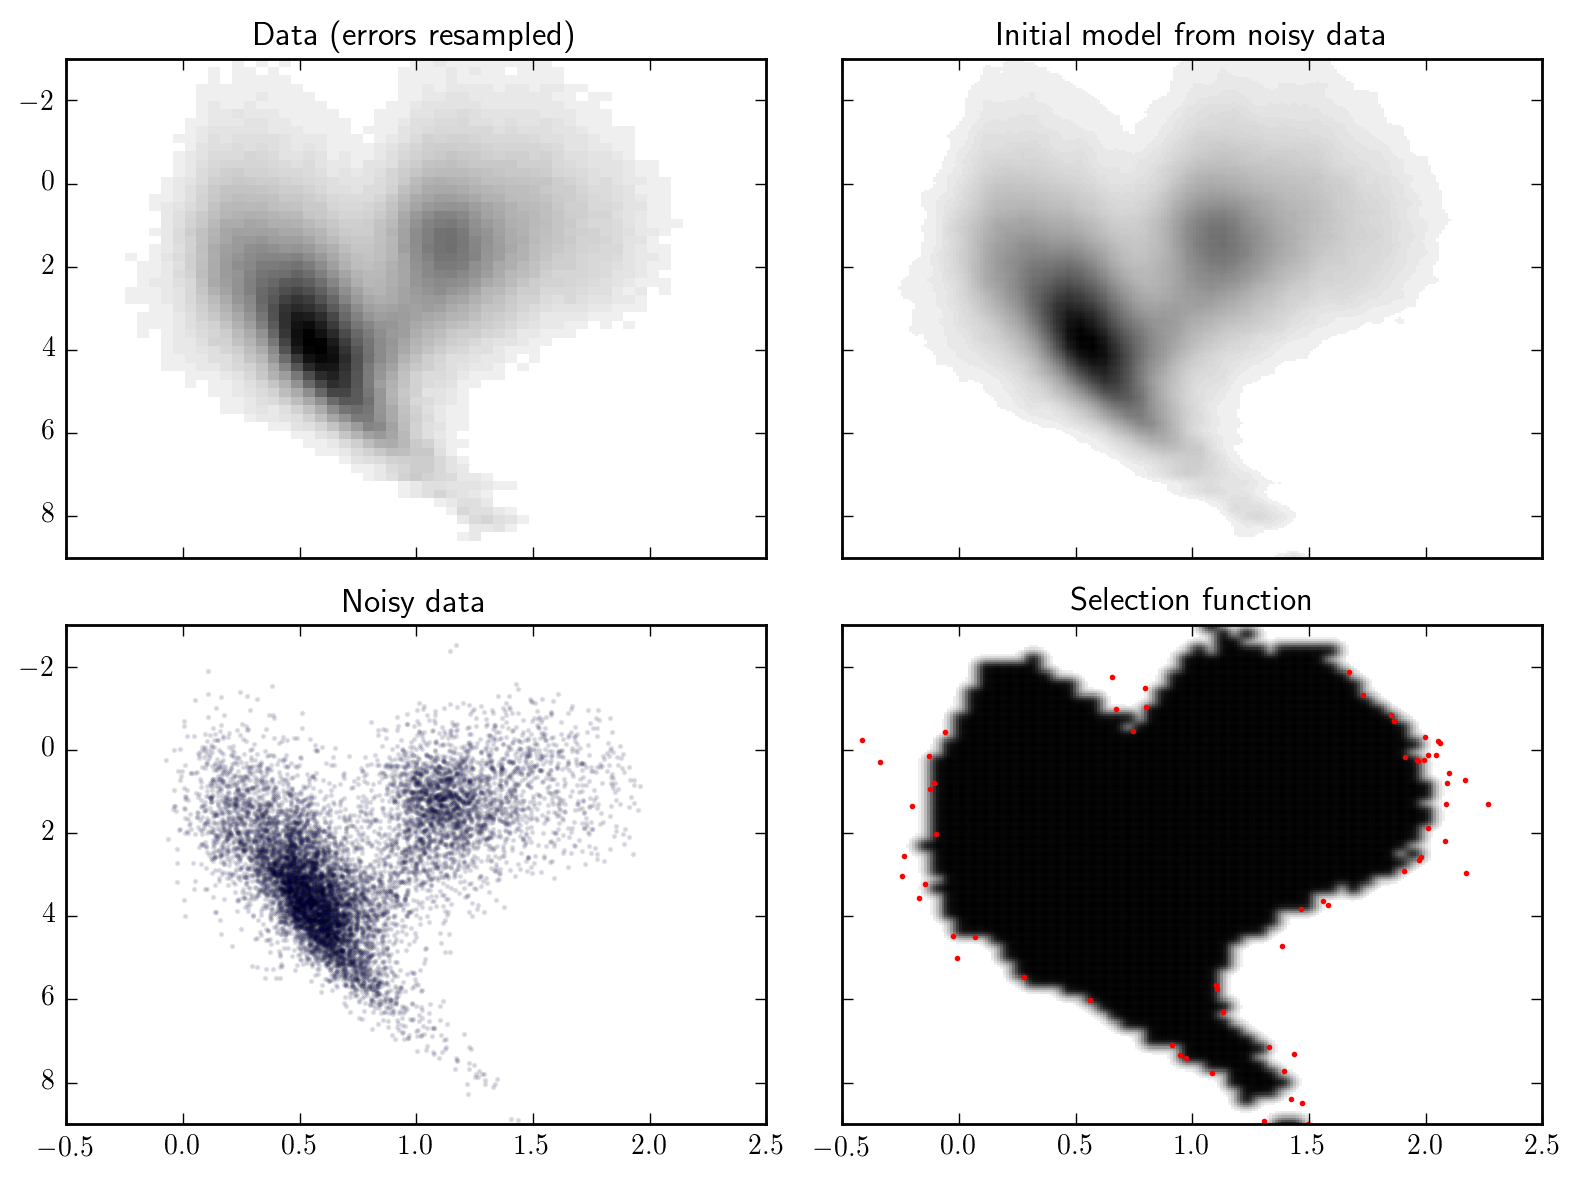

In [14]:
cmap = plt.cm.gray_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(2, 2, figsize=(8, 6), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].pcolormesh(lines[1], lines[0], stacked_counts.T, cmap=cmap, rasterized=True, lw=0)
axs[0].set_title('Data (errors resampled)')
axs[1].pcolormesh(fgrids[1], fgrids[0], naive_model, cmap=cmap, rasterized=True, lw=0)
axs[1].set_title('Initial model from noisy data')
axs[2].scatter(obscolors[inds, 0], obsabsmag[inds], s=1, alpha=0.1)
axs[2].set_title('Noisy data')
axs[3].pcolormesh(fgrids[1], fgrids[0], selectionfct_model, cmap=cmap, rasterized=True, lw=0, zorder=-1)
axs[3].set_title('Selection function')
noinds = np.repeat(True, nobj)
noinds[inds] = False
axs[3].scatter(obscolors[noinds, 0], obsabsmag[noinds], s=1, alpha=1, color='red', zorder=0)
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][0], lines[1][-1])
fig.tight_layout()

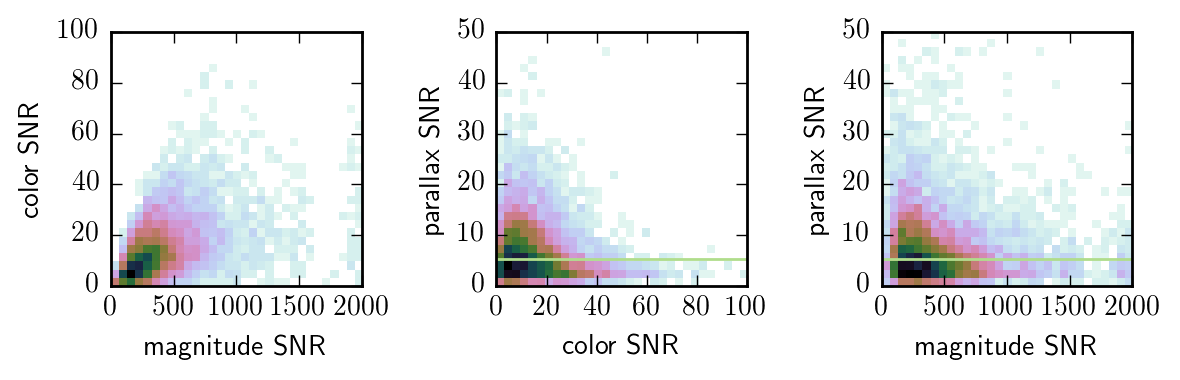

In [15]:
cmap = plt.cm.cubehelix_r
cmap.set_gamma(0.5)
tnbins = 31
fig, axs = plt.subplots(1, 3, figsize=(6, 2))
rr1, rr2, rr3 = 2001, 100, 50
axs[0].hist2d(
    obsmags[ind_training]/obsmags_err[ind_training], 
    obscolors[ind_training, 0]/obscolors_err[ind_training, 0],
    cmap=cmap, bins=tnbins, range=[[0, rr1], [0, rr2]])
axs[1].hist2d(
    obscolors[ind_training, 0]/obscolors_err[ind_training, 0], 
    varpi[ind_training]/varpi_err[ind_training],
    cmap=cmap, bins=tnbins, range=[[0, rr2], [0, rr3]])
axs[2].hist2d(
    obsmags[ind_training]/obsmags_err[ind_training], 
    varpi[ind_training]/varpi_err[ind_training],
    cmap=cmap, bins=tnbins, range=[[0, rr1], [0, rr3]])
axs[1].axhline(snrlim, c=cols[2])
axs[2].axhline(snrlim, c=cols[2])
axs[2].set_ylabel('parallax SNR')
axs[1].set_ylabel('parallax SNR')
axs[1].set_xlabel('color SNR')
axs[0].set_ylabel('color SNR')
axs[0].set_xlabel('magnitude SNR')
axs[2].set_xlabel('magnitude SNR')
fig.tight_layout()

In [16]:
snr_lo = np.min(varpi/varpi_err)
snr_mid = 1*snrlim
snr_hi = np.max(varpi/varpi_err)
print(snr_lo, snr_mid, snr_hi)

1.00009043461 5.26079822695 158.632288031


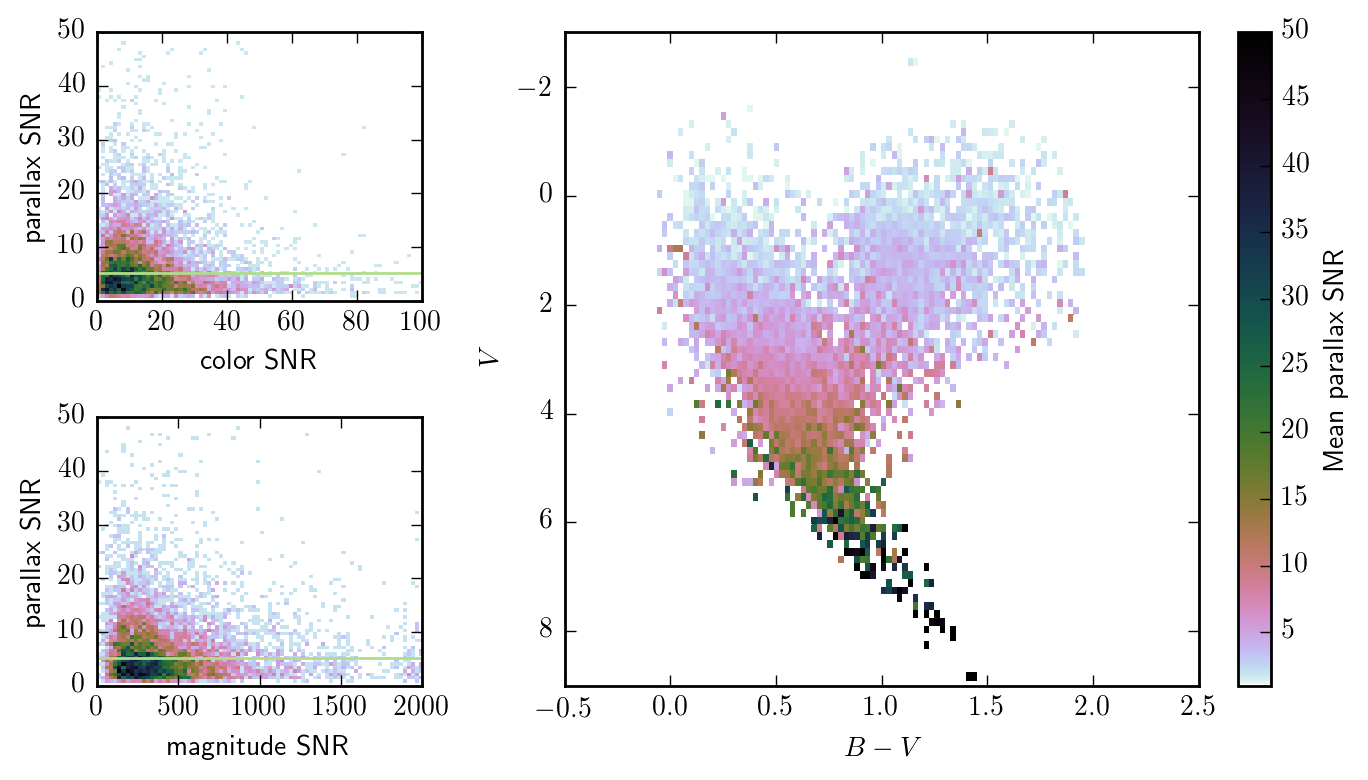

In [17]:
cmap = plt.cm.cubehelix_r
cmap.set_gamma(0.5)
tnbins = 80
fig, axs = plt.subplots(1, 3, figsize=(7, 4))
gs = gridspec.GridSpec(2, 3)
axs = [plt.subplot(gs[0, 0]), plt.subplot(gs[1, 0]), plt.subplot(gs[0:2, 1:3])]
rr1, rr2, rr3 = 2001, 100, 50
axs[0].hist2d(
    obscolors[ind_training, 0]/obscolors_err[ind_training, 0], 
    varpi[ind_training]/varpi_err[ind_training],
    cmap=cmap, bins=tnbins, range=[[0, rr2], [0, rr3]])
axs[1].hist2d(
    obsmags[ind_training]/obsmags_err[ind_training], 
    varpi[ind_training]/varpi_err[ind_training],
    cmap=cmap, bins=tnbins, range=[[0, rr1], [0, rr3]])
axs[0].axhline(snrlim, c=cols[2])
axs[1].axhline(snrlim, c=cols[2])
axs[1].set_ylabel('parallax SNR')
axs[0].set_ylabel('parallax SNR')
axs[0].set_xlabel('color SNR')
axs[1].set_xlabel('magnitude SNR')

meanerrratio, xedges, yedges, binall = scipy.stats.binned_statistic_2d(
    obscolors[ind_training, 0], obsabsmag[ind_training], (varpi[ind_training]/varpi_err[ind_training]), bins=tnbins)
meanerrratio[~np.isfinite(meanerrratio)] = 0
vs = axs[-1].pcolormesh(xedges, yedges, meanerrratio.T, cmap=cmap, vmin=1, vmax=50, rasterized=True, lw=0)
clb = plt.colorbar(vs, ax=axs[-1])
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][0], lines[1][-1])
axs[-1].set_xlabel(r'$B-V$')
axs[-1].set_ylabel(r'$V$')
clb.set_label('Mean parallax SNR')

fig.tight_layout()
fig.savefig('../paper/datasummary.pdf')

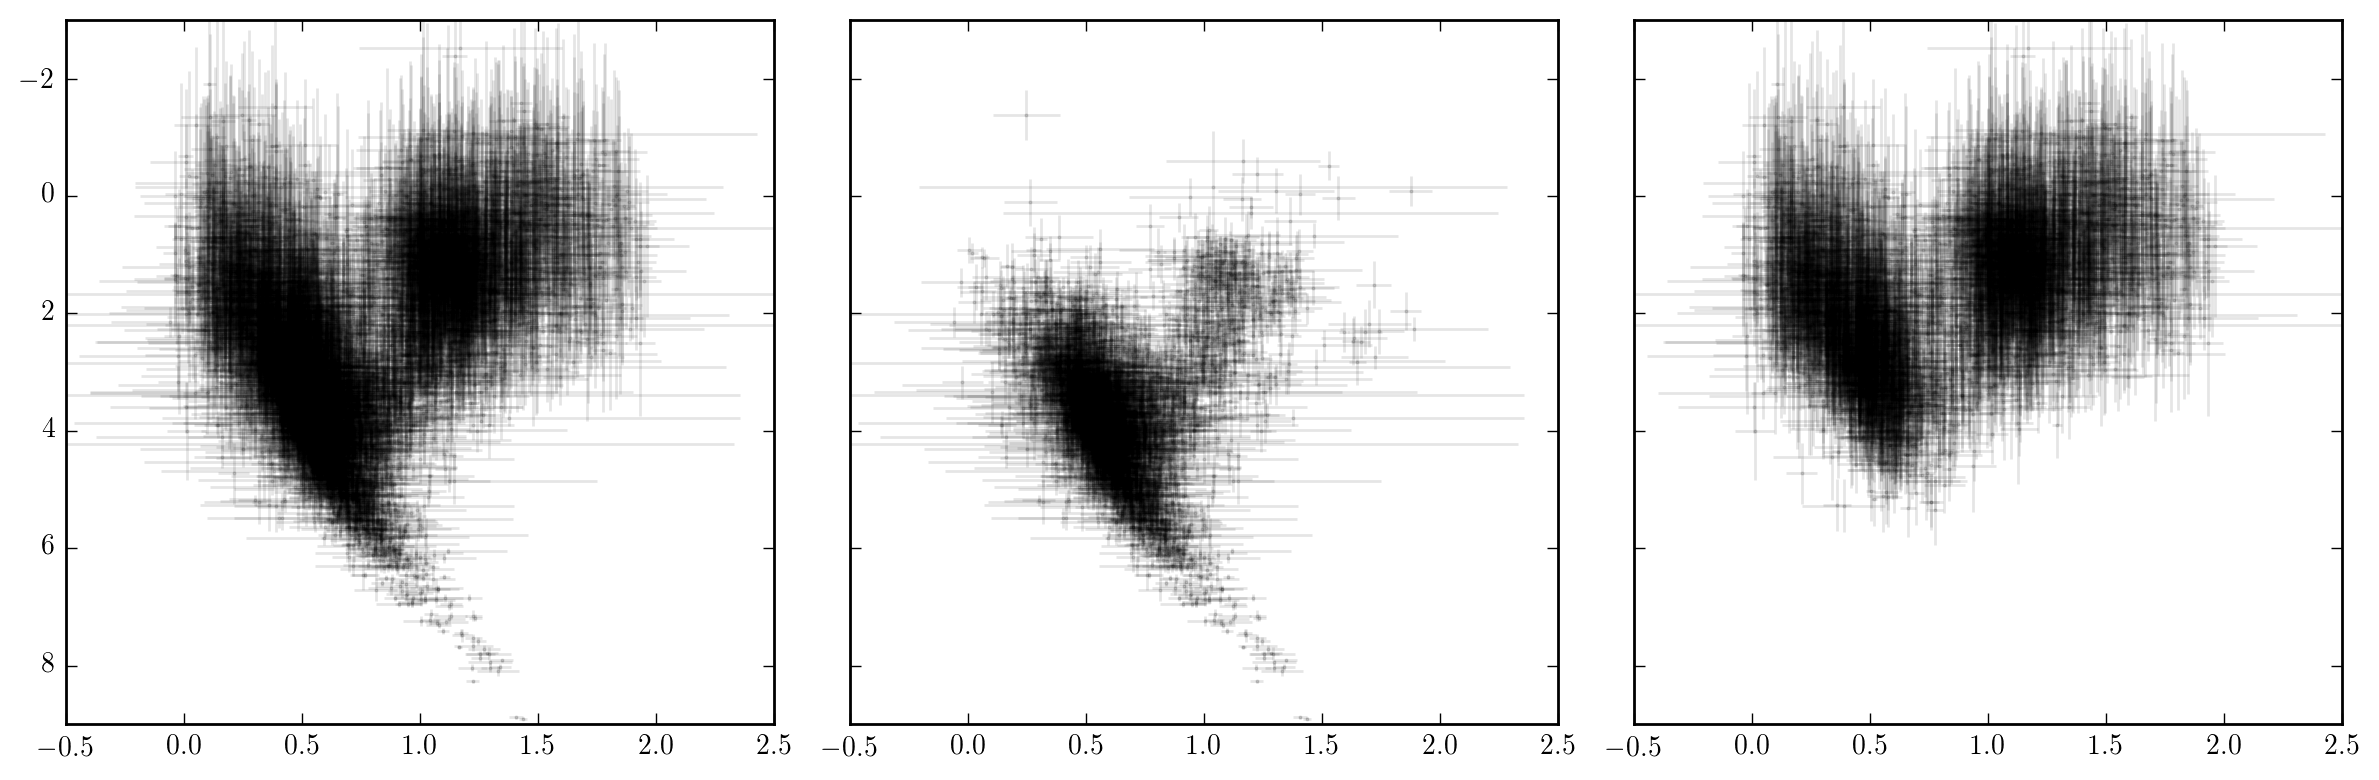

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)
axs = axs.ravel()
yerr = np.sqrt(obsmags_err**2 + (logdist_err)**2)
xerr = obscolors_err
args = {'fmt': 'o', 'markersize': 1, 'color': 'k', 'lw': 1, 'capsize': 0, 'alpha': 0.1}
axs[0].errorbar(obscolors[ind_training],
                obsabsmag[ind_training], 
                yerr=yerr[ind_training],
                xerr=xerr[ind_training],
                **args)
axs[1].errorbar(obscolors[ind_training_best],
                obsabsmag[ind_training_best], 
                yerr=yerr[ind_training_best],
                xerr=xerr[ind_training_best], 
                **args)
axs[2].errorbar(obscolors[ind_training_worst],
                obsabsmag[ind_training_worst], 
                yerr=yerr[ind_training_worst],
                xerr=xerr[ind_training_worst], 
                **args)
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][0], lines[1][-1])
fig.tight_layout()

In [19]:
nobj_sim = 100000
bins_sim = np.random.randint(0, nbins, nobj_sim)
themugs = mugrids[0].ravel()[bins_sim]
thesigs = siggrids[0].ravel()[bins_sim]
absmags_sim = np.random.uniform(themugs-thesigs, themugs+thesigs, nobj_sim)
dist_sim = 20/(absmags_sim + 4)**2 * (1 + 0.2*np.random.randn(nobj_sim))
magserr_sim = 0.03
mags_sim = absmags_sim + 5*np.log10(dist_sim) + 10
mags_sim += magserr_sim*np.random.randn(nobj_sim)
varpierr_sim = 0.4/dist_sim**0.2 * (1 + 0.1*np.random.randn(nobj_sim))
varpi_sim = 1/dist_sim
varpi_sim += varpierr_sim*np.random.randn(nobj_sim)

det = varpi_sim / varpierr_sim > snr_lo
det &= varpi_sim / varpierr_sim < snr_hi
det_best = varpi_sim / varpierr_sim < snr_hi
det_best &= varpi_sim / varpierr_sim > snr_mid
det_worst = varpi_sim / varpierr_sim < snr_mid
det_worst &= varpi_sim / varpierr_sim > snr_lo

In [20]:
ts = (lines[1].size, lines[0].size)
frac_all = np.bincount(bins_sim, minlength=nbins).astype(float)
ii = frac_all > 0
frac_det = np.bincount(bins_sim[det], minlength=nbins).astype(float)
frac_det[ii] /= frac_all[ii]
frac_best = np.bincount(bins_sim[det_best], minlength=nbins).astype(float)
frac_best[ii] /= frac_all[ii]
frac_worst = np.bincount(bins_sim[det_worst], minlength=nbins).astype(float)
frac_worst[ii] /= frac_all[ii]
frac_all = frac_all.reshape(ts)
frac_best = frac_best.reshape(ts)
frac_worst = frac_worst.reshape(ts)
frac_det = frac_det.reshape(ts)
frac_all /= frac_all.max()
print(det.sum(), det_worst.sum(), det_best.sum(), nobj_sim)

86611 36934 49677 100000


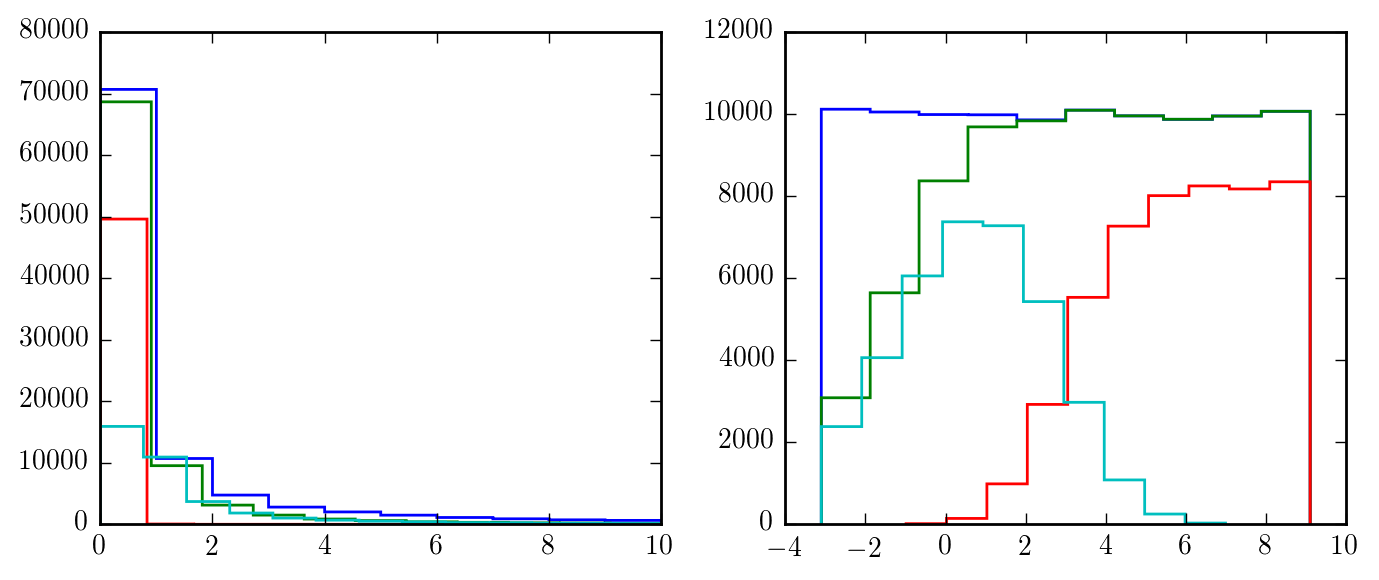

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(7, 3))
axs = axs.ravel()
dmax = 10
axs[0].hist(dist_sim, 10, histtype='step', range=[0, dmax])
axs[0].hist(dist_sim[det], 11, histtype='step', range=[0, dmax])
axs[0].hist(dist_sim[det_best], 12, histtype='step', range=[0, dmax])
axs[0].hist(dist_sim[det_worst], 13, histtype='step', range=[0, dmax])
axs[1].hist(absmags_sim, histtype='step')
axs[1].hist(absmags_sim[det], histtype='step')
axs[1].hist(absmags_sim[det_best], histtype='step')
axs[1].hist(absmags_sim[det_worst], histtype='step')
fig.tight_layout()

In [22]:
# Apply selection function and drop unused bins
binamps_sel = binamps[selection]
binmus_sel, binsigs_sel = binmus[selection, :], binsigs[selection, :]
nbins_sel = selection.size

In [23]:
model = SimpleHRDModel()
num_samples = 1000

In [24]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training], varpi_err[ind_training],
               obsmags[ind_training], obsmags_err[ind_training],
               obscolors[ind_training, :], obscolors_err[ind_training, :], dist_min, dist_max)
bins_samples, binamps_samples = model.gibbs_sampler(num_samples)

Precomputation took 50.85713505744934
Time per sample: 0.00716817 s , 0.000800751 s 


In [25]:
#distances_inf = distances_samples.mean(axis=0)
#distances_inf_std = distances_samples.std(axis=0)
bins_sel_inf = bins_samples.mean(axis=0).astype(int)
binamps_inf, binamps_inf_std = 0*binamps, 0*binamps
binamps_inf[selection] = binamps_samples.mean(axis=0)
binamps_inf_std[selection] = binamps_samples.std(axis=0)
inf_model = hrd(xfine, binamps_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_model_std = hrd(xfine, binamps_inf_std, binmus, binsigs).reshape(fgrids[0].shape)
#print(np.isfinite(distances_samples).sum() / num_samples == distances_samples.shape[1])

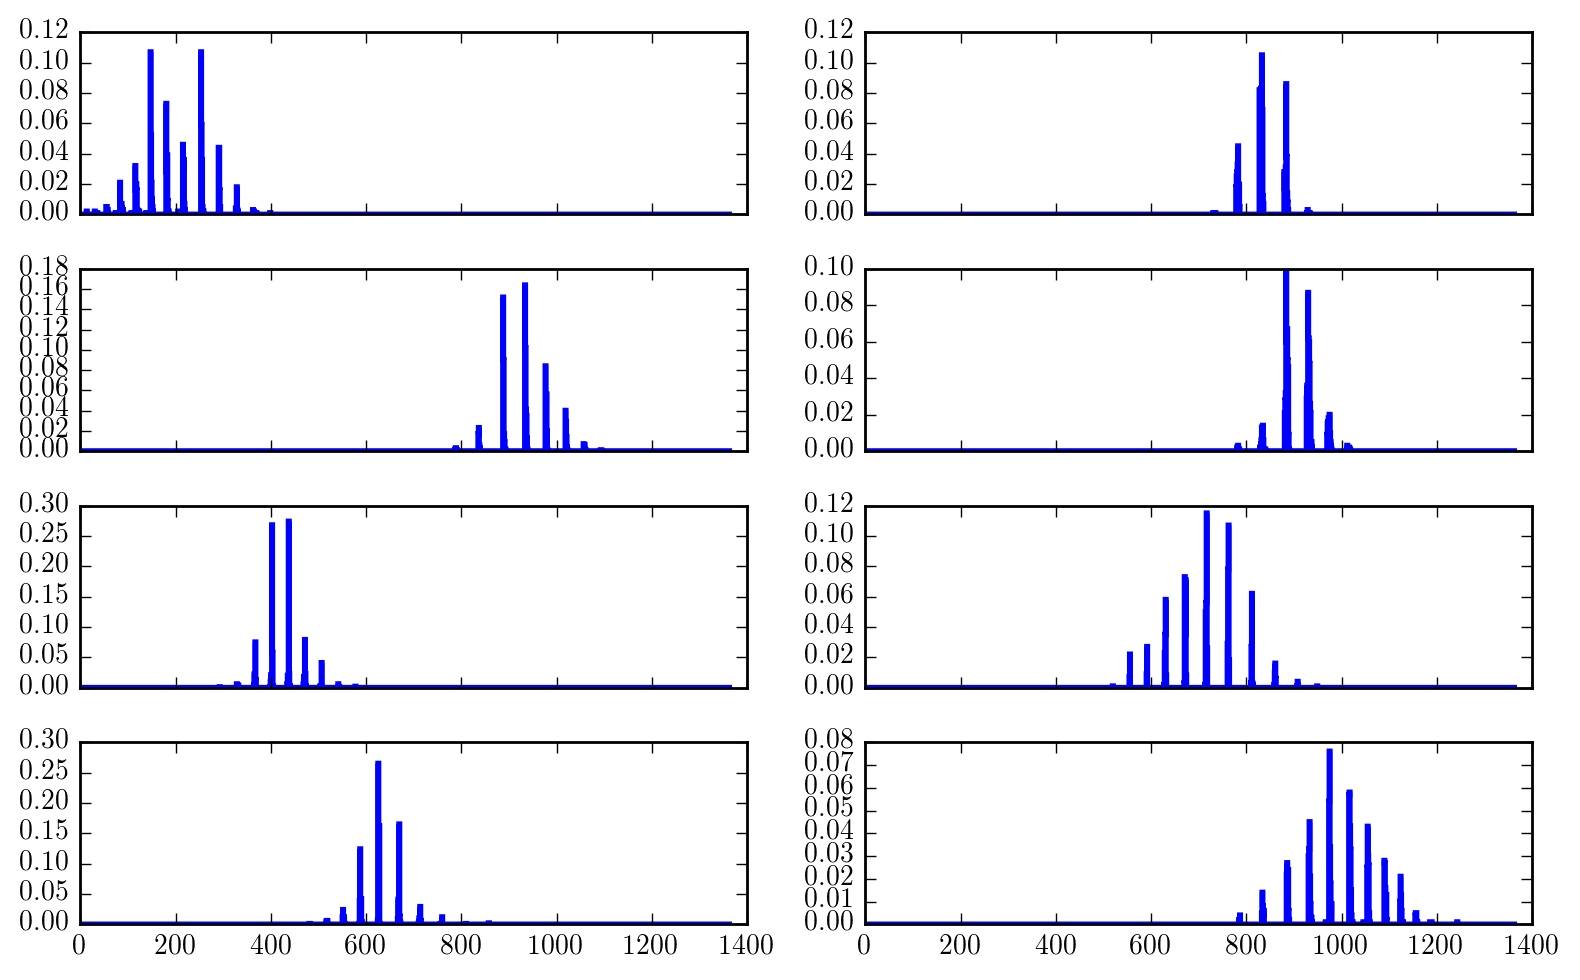

In [26]:
# shrinkage of distances in training set
# TODO: better representation of bin locations (in 2D plane with sample average)
#distances_samples2 = np.vstack([1/(varpi[ind_training] + varpi_err[ind_training]*np.random.randn(ind_training.size)) for i in range(num_samples)])
#distances = distances_samples.mean(axis=0)
#distances2 = 1/varpi[ind_training]
fig, axs = plt.subplots(4, 2, figsize=(8, 5), sharex=True)
axs = axs.ravel()
varpi_fracerror = varpi_err / varpi
js = np.arange(ind_training.size)
#js = np.where(dist_err < 0.01 )[0]
np.random.shuffle(js)
js = js[:axs.shape[0]]

for i in range(axs.shape[0]):
    axs[i].hist(bins_samples[:, js[i]], nbins_sel, histtype='step', lw=2, normed=True, range=[0, nbins_sel])
    #axs[i, 0].plot(tgrid[i, :], ls='steps')
    #axs[i, 1].hist(distances_samples[:, js[i]], 30, normed=True, color='b', histtype='step', lw=2)#, range=[0, dist_max])
    #ind2 = distances_samples2[:, js[i]] > 0
    #ind2 &= distances_samples2[:, js[i]] < dist_max
    #axs[i, 1].hist(distances_samples2[ind2, js[i]], 30, normed=True, color='r', histtype='step', lw=2)#, range=[0, dist_max])
    #axs[i, 1].axvline(distances[js[i]], c='b', lw=2)
    #axs[i, 1].axvline(distances2[js[i]], c='r', lw=2, ls='--')
    #y = probgrid_mean[js[i], :] / np.trapz(probgrid_mean[js[i], :], x=distances_grid)
    #axs[i, 1].plot(distances_grid, y)
fig.tight_layout()

In [27]:
stacked_counts = None
nsamp = 100
for i in range(nsamp):
    ran_colors = obscolors[ind_training, 0] + obscolors_err[ind_training, 0]*np.random.randn(ind_training.size)
    ran_obsmags = obsmags[ind_training] + obsmags_err[ind_training]*np.random.randn(ind_training.size)
    ran_dist = 1/(varpi[ind_training] + varpi_err[ind_training]*np.random.randn(ind_training.size))
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10

    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, bins=[flines[1], flines[0]])
    if stacked_counts is None:
        stacked_counts = counts / nsamp
    else:
        stacked_counts += counts / nsamp

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:14: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


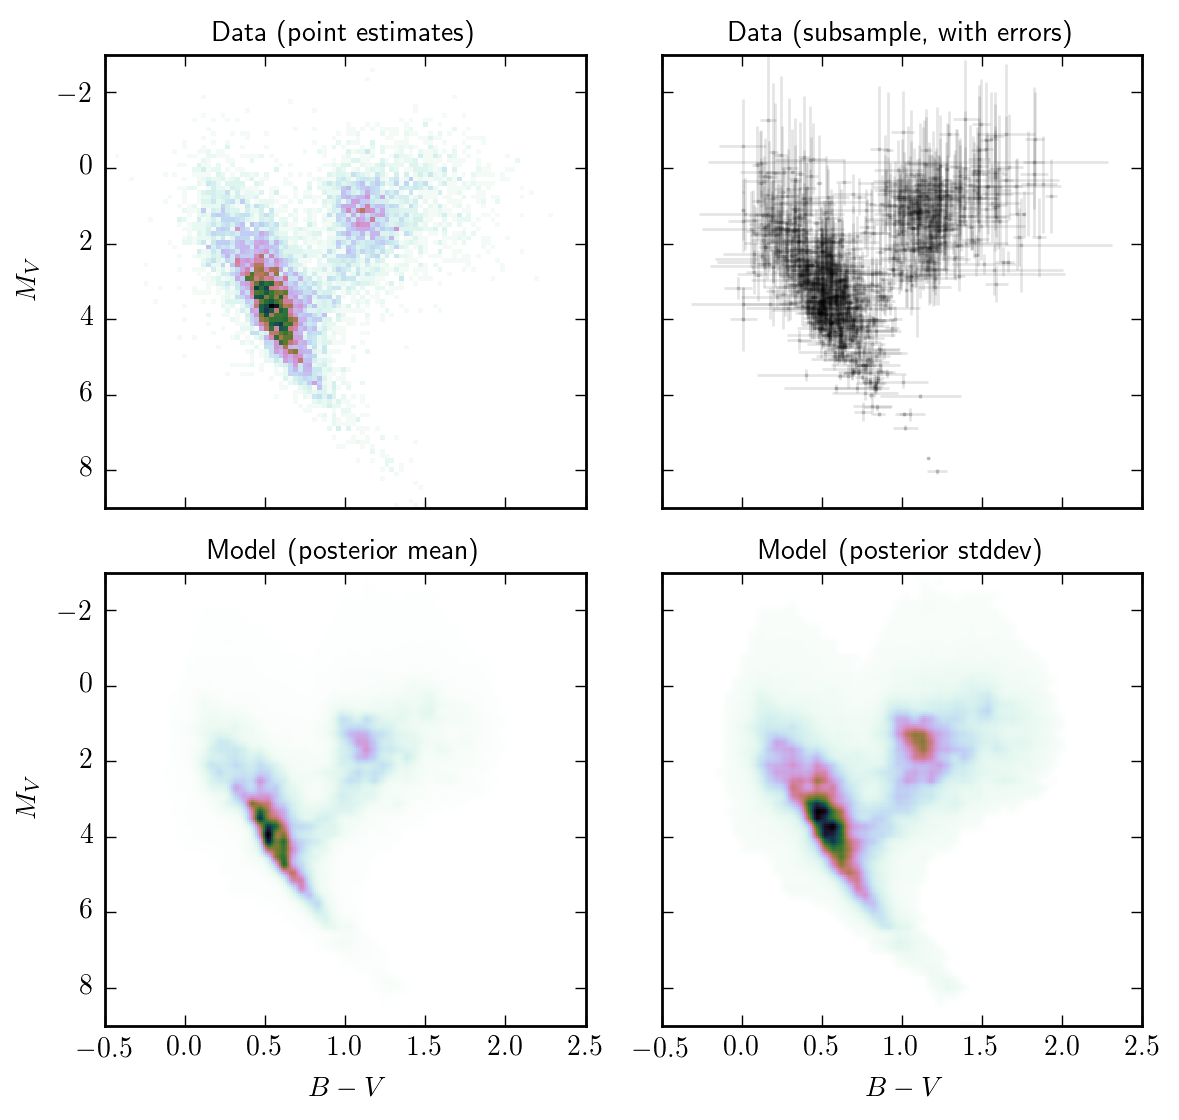

In [30]:
cmap = plt.cm.cubehelix_r # CMRmap #coolwarm# YlGnBu_r
cmap.set_gamma(1)
fig, axs = plt.subplots(2, 2, figsize=(6, 5.7), sharex=True, sharey=True)
axs = axs.ravel()
fs = 10
axs[0].hist2d(obscolors[:, 0], obsabsmag, 100,
              range=[[lines[1][0], lines[1][-1]], [lines[0][0], lines[0][-1]]],
              cmap=cmap, rasterized=True)
axs[0].set_title('Data (point estimates)', fontsize=fs)
#axs[1].pcolormesh(flines[1], flines[0], stacked_counts.T, cmap=cmap, rasterized=True, lw=0)
#axs[1].set_title('Data (errors resampled)', fontsize=fs)
ind2 = 1*ind_training
if ind_training.size > 1e3:
    ind2 = ind2[:1e3]
args = {'fmt': 'o', 'markersize': 1, 'color': 'k', 'lw': 1, 'capsize': 0, 'alpha': 0.1}
axs[1].errorbar(obscolors[ind2],
                obsabsmag[ind2], 
                yerr=yerr[ind2],
                xerr=xerr[ind2],
                **args)
axs[1].set_title('Data (subsample, with errors)', fontsize=fs)
axs[2].pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap, rasterized=True, lw=0)
axs[2].set_title('Model (posterior mean)', fontsize=fs)
vs = axs[3].pcolormesh(fgrids[1], fgrids[0], inf_model_std, cmap=cmap, rasterized=True, lw=0)
axs[3].set_title('Model (posterior stddev)', fontsize=fs)
axs[0].set_ylim(lines[0][-1], lines[0][0])
axs[0].set_xlim(lines[1][0], lines[1][-1])
axs[2].set_xlabel(r'$B-V$')
axs[0].set_ylabel(r'$M_V$')
axs[3].set_xlabel(r'$B-V$')
axs[2].set_ylabel(r'$M_V$')
#clb = plt.colorbar(vs, ax=axs.ravel().tolist(), ticks=[])
fig.tight_layout()
#fig.subplots_adjust(wspace=.01, right=0.8)
fig.savefig('../paper/colmagdiag_mainsample.pdf')

In [31]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training_best], varpi_err[ind_training_best],
               obsmags[ind_training_best], obsmags_err[ind_training_best],
               obscolors[ind_training_best, :], obscolors_err[ind_training_best, :], dist_min, dist_max)
bins_samples_best, binamps_samples_best = model.gibbs_sampler(num_samples)

Precomputation took 24.997684955596924
Time per sample: 0.00450511 s , 0.000806885 s 


In [32]:
model.set_data(binmus_sel, binsigs_sel,
               varpi[ind_training_worst], varpi_err[ind_training_worst],
               obsmags[ind_training_worst], obsmags_err[ind_training_worst],
               obscolors[ind_training_worst, :], obscolors_err[ind_training_worst, :], dist_min, dist_max)
bins_samples_worst, binamps_samples_worst = model.gibbs_sampler(num_samples)

Precomputation took 27.932260990142822
Time per sample: 0.0032878 s , 0.000775187 s 


In [33]:
binamps_best_inf, binamps_best_inf_std = 0*binamps, 0*binamps
binamps_best_inf[selection] = binamps_samples_best.mean(axis=0)
binamps_best_inf_std[selection] = binamps_samples_best.std(axis=0)
inf_best_model = hrd(xfine, binamps_best_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_best_model_std = hrd(xfine, binamps_best_inf_std, binmus, binsigs).reshape(fgrids[0].shape)

In [34]:
binamps_worst_inf, binamps_worst_inf_std = 0*binamps, 0*binamps
binamps_worst_inf[selection] = binamps_samples_worst.mean(axis=0)
binamps_worst_inf_std[selection] = binamps_samples_worst.std(axis=0)
inf_worst_model = hrd(xfine, binamps_worst_inf, binmus, binsigs).reshape(fgrids[0].shape)
inf_worst_model_std = hrd(xfine, binamps_worst_inf_std, binmus, binsigs).reshape(fgrids[0].shape)

In [35]:
stacked_counts = None
stacked_counts_best = None
stacked_counts_worst = None
nsamp = 1000
for i in range(nsamp):
    ran_colors = obscolors[:, 0] + obscolors_err[:, 0]*np.random.randn(nobj)
    ran_obsmags = obsmags[:] + obsmags_err[:]*np.random.randn(nobj)
    ran_varpi = varpi[:] + varpi_err[:]*np.random.randn(nobj)
    ran_dist = 1. / ran_varpi
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10
    ind_worst = ran_varpi / varpi_err < snr_mid
    ind_best = ran_varpi / varpi_err > snr_mid
    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, range=[[lines[1][0], lines[1][-1]], 
                                                                  [lines[0][0], lines[0][-1]]],
                                 bins=[lines[0].size, lines[0].size])
    counts_best, _, _ = np.histogram2d(ran_colors[ind_best], ran_absmags[ind_best],
                                       range=[[lines[1][0], lines[1][-1]], 
                                              [lines[0][0], lines[0][-1]]],
                                 bins=[lines[0].size, lines[0].size])
    counts_worst, _, _ = np.histogram2d(ran_colors[ind_worst], ran_absmags[ind_worst],
                                        range=[[lines[1][0], lines[1][-1]], 
                                               [lines[0][0], lines[0][-1]]],
                                 bins=[lines[0].size, lines[0].size])
    if stacked_counts is None:
        stacked_counts = counts / nsamp
        stacked_counts_best = counts_best / nsamp
        stacked_counts_worst = counts_worst / nsamp
    else:
        stacked_counts += counts / nsamp
        stacked_counts_best += counts_best / nsamp
        stacked_counts_worst += counts_worst / nsamp
        
ii = stacked_counts > 0
detprod_best = 0*stacked_counts_best
detprod_best[ii] = stacked_counts_best[ii] / stacked_counts[ii]
detprod_worst = 0*stacked_counts_worst
detprod_worst[ii] = stacked_counts_worst[ii] / stacked_counts[ii]

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in log10
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


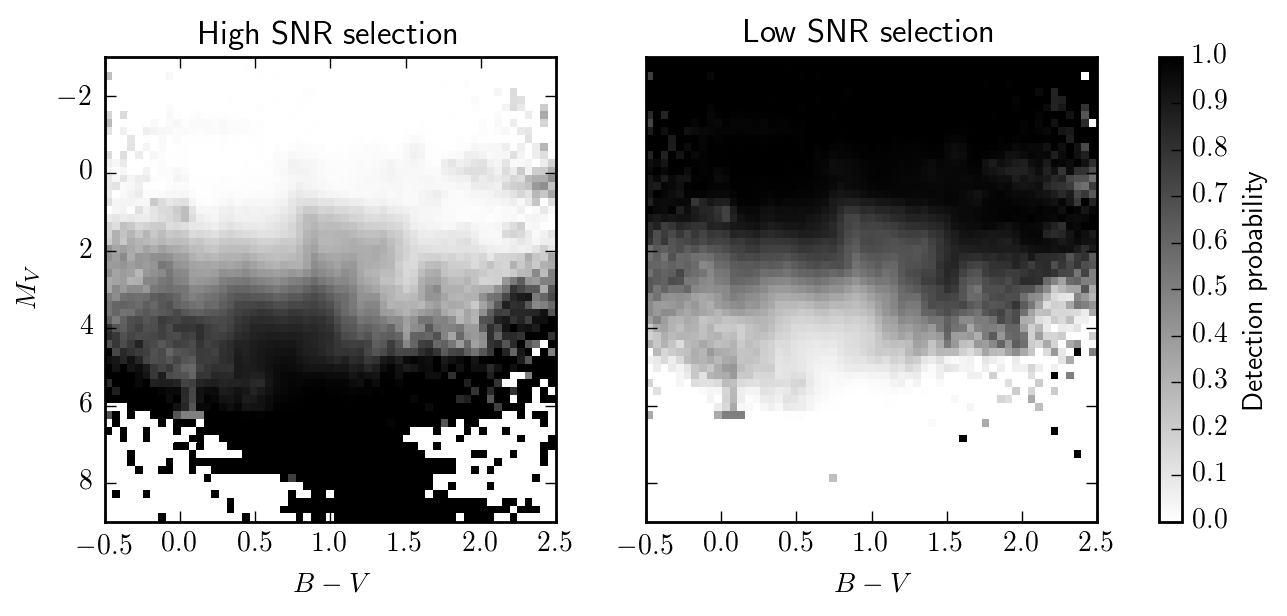

In [36]:
cmap = plt.cm.gray_r
cmap.set_gamma(1)
fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharex=True, sharey=True)
axs = axs.ravel()
axs[0].set_title('High SNR selection')
axs[1].set_title('Low SNR selection')
#axs[0].axhline(3, ls='dashed', lw=2)
#axs[1].axhline(3, ls='dashed', lw=2)
axs[0].pcolormesh(lines[1], lines[0], detprod_best.T, cmap=cmap, rasterized=True, lw=0)
vs = axs[1].pcolormesh(lines[1], lines[0], detprod_worst.T, cmap=cmap, rasterized=True, lw=0)
axs[-1].set_ylim(lines[0][-1], lines[0][0])
axs[-1].set_xlim(lines[1][0], lines[1][-1])
axs[0].set_xlabel(r'$B-V$')
axs[1].set_xlabel(r'$B-V$')
axs[0].set_ylabel(r'$M_V$')
clb = plt.colorbar(vs, ax=axs.ravel().tolist())
clb.set_label('Detection probability')
#fig.tight_layout()

In [37]:
nsamp = 100

stacked_counts_worst = None
for i in range(nsamp):
    ran_colors = obscolors[ind_training_worst, 0] + obscolors_err[ind_training_worst, 0]*np.random.randn(ind_training_worst.size)
    ran_obsmags = obsmags[ind_training_worst] + obsmags_err[ind_training_worst]*np.random.randn(ind_training_worst.size)
    ran_dist = 1/(varpi[ind_training_worst] + varpi_err[ind_training_worst]*np.random.randn(ind_training_worst.size))
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10

    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, bins=[flines[1], flines[0]])
    if stacked_counts_worst is None:
        stacked_counts_worst = counts / nsamp
    else:
        stacked_counts_worst += counts / nsamp
        
stacked_counts_best = None
for i in range(nsamp):
    ran_colors = obscolors[ind_training_best, 0] + obscolors_err[ind_training_best, 0]*np.random.randn(ind_training_best.size)
    ran_obsmags = obsmags[ind_training_best] + obsmags_err[ind_training_best]*np.random.randn(ind_training_best.size)
    ran_dist = 1/(varpi[ind_training_best] + varpi_err[ind_training_best]*np.random.randn(ind_training_best.size))
    ran_absmags = ran_obsmags - 5*np.log10(ran_dist) - 10

    counts, _, _ = np.histogram2d(ran_colors, ran_absmags, bins=[flines[1], flines[0]])
    if stacked_counts_best is None:
        stacked_counts_best = counts / nsamp
    else:
        stacked_counts_best += counts / nsamp

/Users/bl/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in log10
/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


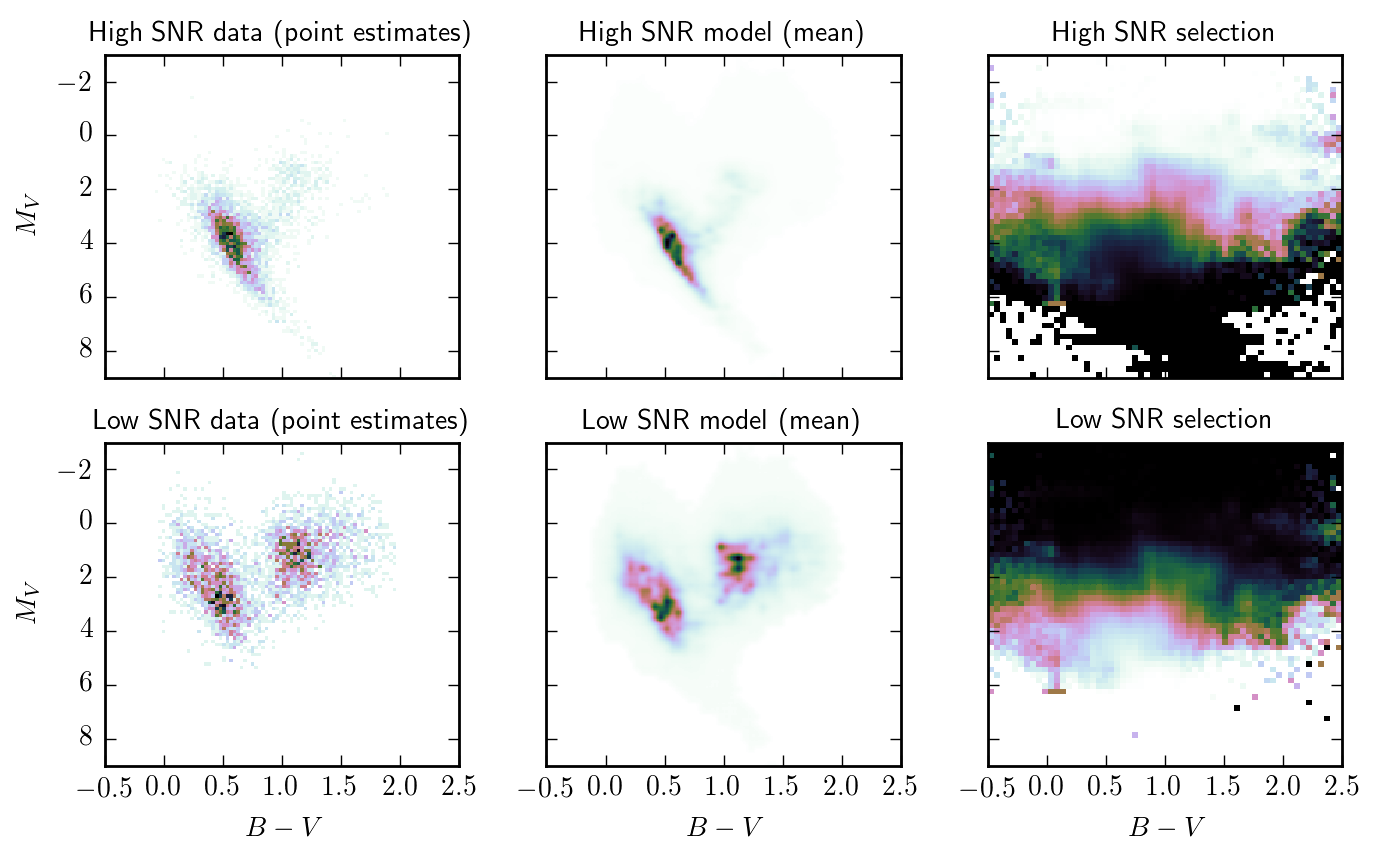

In [40]:
cmap = plt.cm.cubehelix_r
cmap.set_gamma(1)
fig, axs = plt.subplots(2, 3, figsize=(7, 4.4), sharex=True, sharey=True)
#axs[0, 0].set_title('High SNR data (resampled)', fontsize=fs)
axs[0, 1].set_title('High SNR model (mean)', fontsize=fs)
axs[0, 2].set_title('High SNR selection', fontsize=fs)
#axs[0, 2].set_title('High SNR model (stddev)', fontsize=fs)
#axs[1, 0].set_title('Low SNR data (resampled)', fontsize=fs)
axs[1, 1].set_title('Low SNR model (mean)', fontsize=fs)
#axs[1, 2].set_title('Low SNR model (stddev)', fontsize=fs)
axs[1, 2].set_title('Low SNR selection', fontsize=fs)
axs[1, 0].set_title('Low SNR data (point estimates)', fontsize=fs)
axs[0, 0].set_title('High SNR data (point estimates)', fontsize=fs)
axs[0, 0].hist2d(obscolors[ind_training_best, 0], obsabsmag[ind_training_best], 100,
              range=[[lines[1][0], lines[1][-1]], [lines[0][0], lines[0][-1]]],
              cmap=cmap, rasterized=True)
axs[1, 0].hist2d(obscolors[ind_training_worst, 0], obsabsmag[ind_training_worst], 100,
              range=[[lines[1][0], lines[1][-1]], [lines[0][0], lines[0][-1]]],
              cmap=cmap, rasterized=True)
#axs[0, 0].pcolormesh(flines[1], flines[0], stacked_counts_best.T, cmap=cmap, rasterized=True, lw=0)
axs[0, 1].pcolormesh(fgrids[1], fgrids[0], inf_best_model, cmap=cmap, rasterized=True, lw=0)
#axs[0, 2].pcolormesh(fgrids[1], fgrids[0], inf_best_model_std, cmap=cmap, rasterized=True, lw=0)
#axs[1, 0].pcolormesh(flines[1], flines[0], stacked_counts_worst.T, cmap=cmap, rasterized=True, lw=0)
axs[1, 1].pcolormesh(fgrids[1], fgrids[0], inf_worst_model, cmap=cmap, rasterized=True, lw=0)
#axs[1, 2].pcolormesh(fgrids[1], fgrids[0], inf_worst_model_std, cmap=cmap, rasterized=True, lw=0)
axs[0, 2].pcolormesh(lines[1], lines[0], detprod_best.T, cmap=cmap, rasterized=True, lw=0)
axs[1, 2].pcolormesh(lines[1], lines[0], detprod_worst.T, cmap=cmap, rasterized=True, lw=0)
axs[0, 0].set_ylim(lines[0][-1], lines[0][0])
axs[0, 0].set_xlim(lines[1][0], lines[1][-1])
for i in range(3):
    axs[1, i].set_xlabel(r'$B-V$')
for i in range(2):
    axs[i, 0].set_ylabel(r'$M_V$')
fig.tight_layout()
fig.savefig('../paper/colmagdiag_othersamples.pdf')

In [37]:
ndistg = 100
fac = 6
muds = 1./varpi[ind_training]
sigds = varpi_err[ind_training]/varpi[ind_training]**2
dist_mins = muds - fac*sigds
dist_mins[dist_mins < dist_min] = dist_min
dist_maxs = muds + fac*sigds
dist_maxs[dist_maxs > dist_max] = dist_max
dist_deltas = (dist_maxs - dist_mins) / (ndistg - 1)
distance_grids = dist_mins[:, None] + dist_deltas[:, None] * np.arange(ndistg)[None, :]

In [38]:
# shrinkage of distances in training set
probgrid_mean = np.zeros((ind_training.size, ndistg))
binamps_sel_val = binamps_samples.mean(axis=0)
prob_distgrids_marg(
                probgrid_mean, ndistg, distance_grids,
                ind_training.size, nbins_sel, ncols,
                varpi[ind_training], varpi_err[ind_training],
                obsmags[ind_training], obsmags_err[ind_training],
                obscolors[ind_training, :], obscolors_err[ind_training, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

probgrid_flat = np.zeros((ind_training.size, ndistg))
binamps_sel_val[:] = 1./nbins
prob_distgrids_marg(
                probgrid_flat, ndistg, distance_grids,
                ind_training.size, nbins_sel, ncols,
                varpi[ind_training], varpi_err[ind_training],
                obsmags[ind_training], obsmags_err[ind_training],
                obscolors[ind_training, :], obscolors_err[ind_training, :],
                binamps_sel_val, binmus_sel, binsigs_sel)
mean_vals1 = np.zeros((ind_training.size, ))
std_vals1 = np.zeros((ind_training.size, ))
mean_vals2 = np.zeros((ind_training.size, ))
std_vals2 = np.zeros((ind_training.size, ))
for o in range(ind_training.size):
    if probgrid_mean[o, :].sum() > 0:
        mean_vals2[o] = np.average(distance_grids[o, :], weights=probgrid_mean[o, :])
        std_vals2[o] = np.average((distance_grids[o, :] - mean_vals2[o])**2, weights=probgrid_mean[o, :])**0.5
    if probgrid_flat[o, :].sum() > 0:
        mean_vals1[o] = np.average(distance_grids[o, :], weights=probgrid_flat[o, :])
        std_vals1[o] = np.average((distance_grids[o, :] - mean_vals1[o])**2, weights=probgrid_flat[o, :])**0.5

In [39]:
snr1 = mean_vals1 / std_vals1
snr2 = mean_vals2 / std_vals2
nobj = ind_training.size
ind = snr1 > 0
ind &= snr2 > 0
ind &= snr1 < 100
ind &= snr2 < 100
print('Mean SNR ratio (increase):', np.mean((snr2/snr1)[ind]))
print('Mean disterr', np.mean((std_vals1/std_vals2)[ind]))
ind = std_vals2 / std_vals1 < 0.5
print('Fraction of objects where disterr is halved:', 100 * np.sum(ind) / ind.size)

Mean SNR ratio (increase): 1.12645879221
Mean disterr 1.27379903822
Fraction of objects where disterr is halved: 2.35651131425


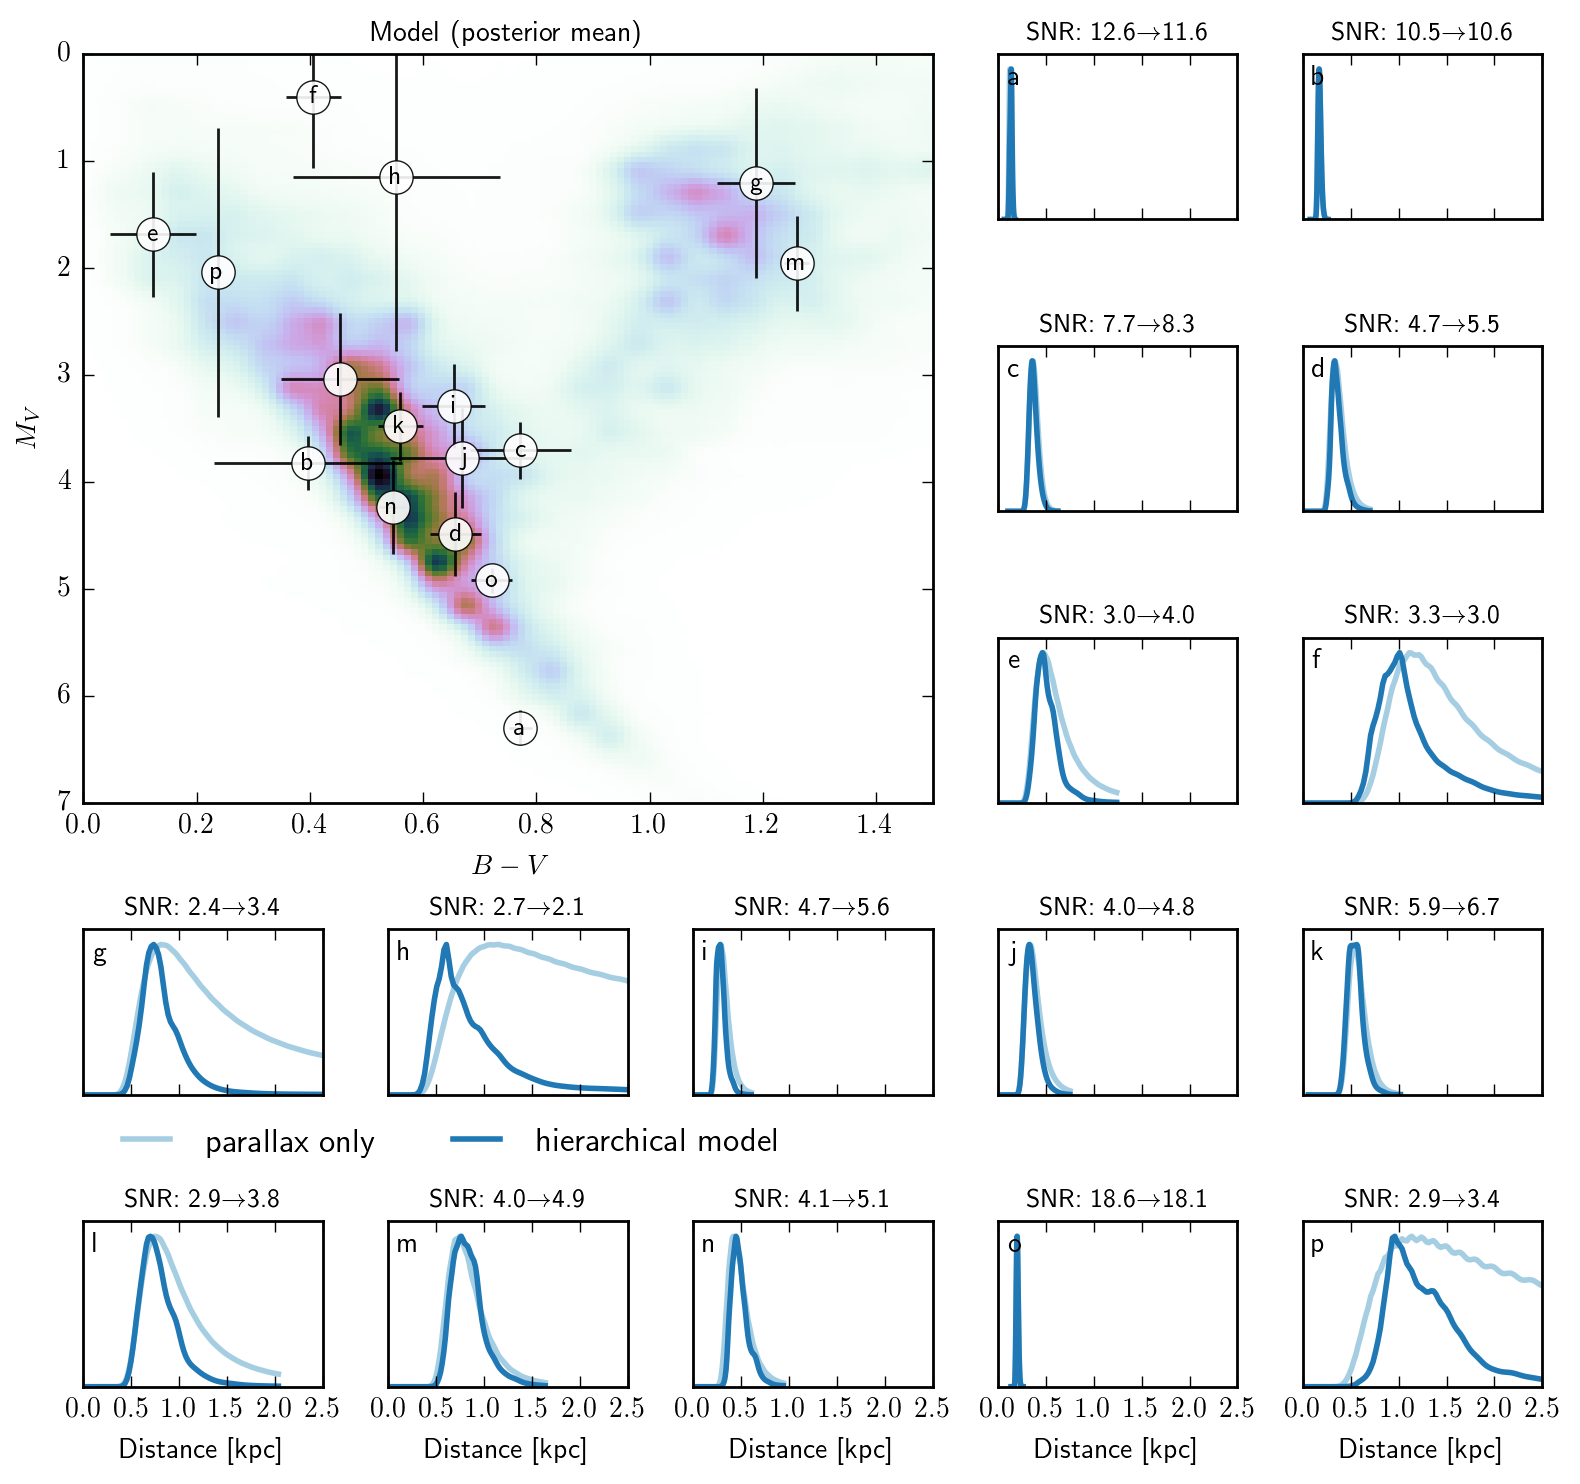

In [40]:
nc = 5
fig, axs = plt.subplots(nc, nc, figsize=(8, 8), sharex=True, sharey=True)
gs = gridspec.GridSpec(nc, nc)
off = 3
axs = [plt.subplot(gs[0:off, 0:off])]
for i in range(nc):
    for j in range(nc):
        if i >= off or j >= off:
            axs.extend([plt.subplot(gs[i, j])])

cmap = plt.cm.cubehelix_r 
cmap.set_gamma(1)
axs[0].pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap, rasterized=True, lw=0)
axs[0].set_title('Model (posterior mean)', fontsize=fs)
axs[0].set_ylim([7, 0])#lines[0][-1], lines[0][0])
axs[0].set_xlim([0, 1.5])#lines[1][0], lines[1][-1])
axs[0].set_xlabel(r'$B-V$')
axs[0].set_ylabel(r'$M_V$')

args = {'fmt': 'o', 'markerfacecolor': 'w', 'markersize': 12, 'color': 'k', 'lw': 1, 'capsize': 0, 'alpha': 0.9}
alphabet = [code for code in range(ord('a'), ord('z') + 1)]

for i in range(nc):
    axs[-i-1].set_xlabel('Distance [kpc]')
dist_val = 1/varpi[ind_training]
dist_err_val = varpi_err[ind_training] / varpi[ind_training]**2
snr1 = mean_vals1 / std_vals1
snr2 = mean_vals2 / std_vals2
ind3 = snr2 > snr1 * 1.2
ind3 &= snr2 < 10
js = np.random.choice(np.where(ind3)[0], len(axs), replace=False)
js = np.array([1950, 1071, 7626, 1897, 2295, 1610, 2144, 2851, 8152, 8696, 2134,
       3405,  684, 4260, 5961, 1907, 2523])
for i in range(1, len(axs)):
    y = probgrid_flat[js[i], :]/np.max(probgrid_flat[js[i], :])
    ind = y > 0.01
    axs[i].plot(distance_grids[js[i], :], y[:], c=cols[0], lw=2, label='parallax only')
    y = probgrid_mean[js[i], :]/np.max(probgrid_mean[js[i], :])
    ind = y > 0.01
    axs[i].plot(distance_grids[js[i], :], y[:], c=cols[1], lw=2, label='hierarchical model')
    axs[i].set_yticks([])
    axs[i].set_ylim([0, 1.1])
    axs[i].set_title('SNR: %.1f' % snr1[js[i]] + r'$\rightarrow$' + '%.1f' % snr2[js[i]], fontsize=9)
    txt = chr(alphabet[i-1])
    axs[i].text(0.1, 0.9, txt)
    axs[0].errorbar(obscolors[ind_training[js[i]]],
                    obsabsmag[ind_training[js[i]]], 
                    yerr=yerr[ind_training[js[i]]],
                    xerr=xerr[ind_training[js[i]]], **args)
    axs[0].annotate(txt, (0.0+obscolors[ind_training[js[i]]], 0.+obsabsmag[ind_training[js[i]]]),
                   horizontalalignment='center', verticalalignment='center', fontsize=9)
    #axs[i].text(1.35, 0.85, 'SNR: %.1f' % snr1[js[i]] + r'$\rightarrow$' + '%.1f' % snr2[js[i]],
    #            fontsize=9, bbox=dict(facecolor='white', edgecolor='w', pad=0, alpha=0.75))
    axs[i].set_xlim([0, dist_max])
    if i < len(axs) - nc:
        axs[i].set_xticklabels([])
axs[-nc].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.75))
fig.tight_layout()
fig.subplots_adjust(top=0.9)
fig.savefig('../paper/model_dist_pdfs.pdf')

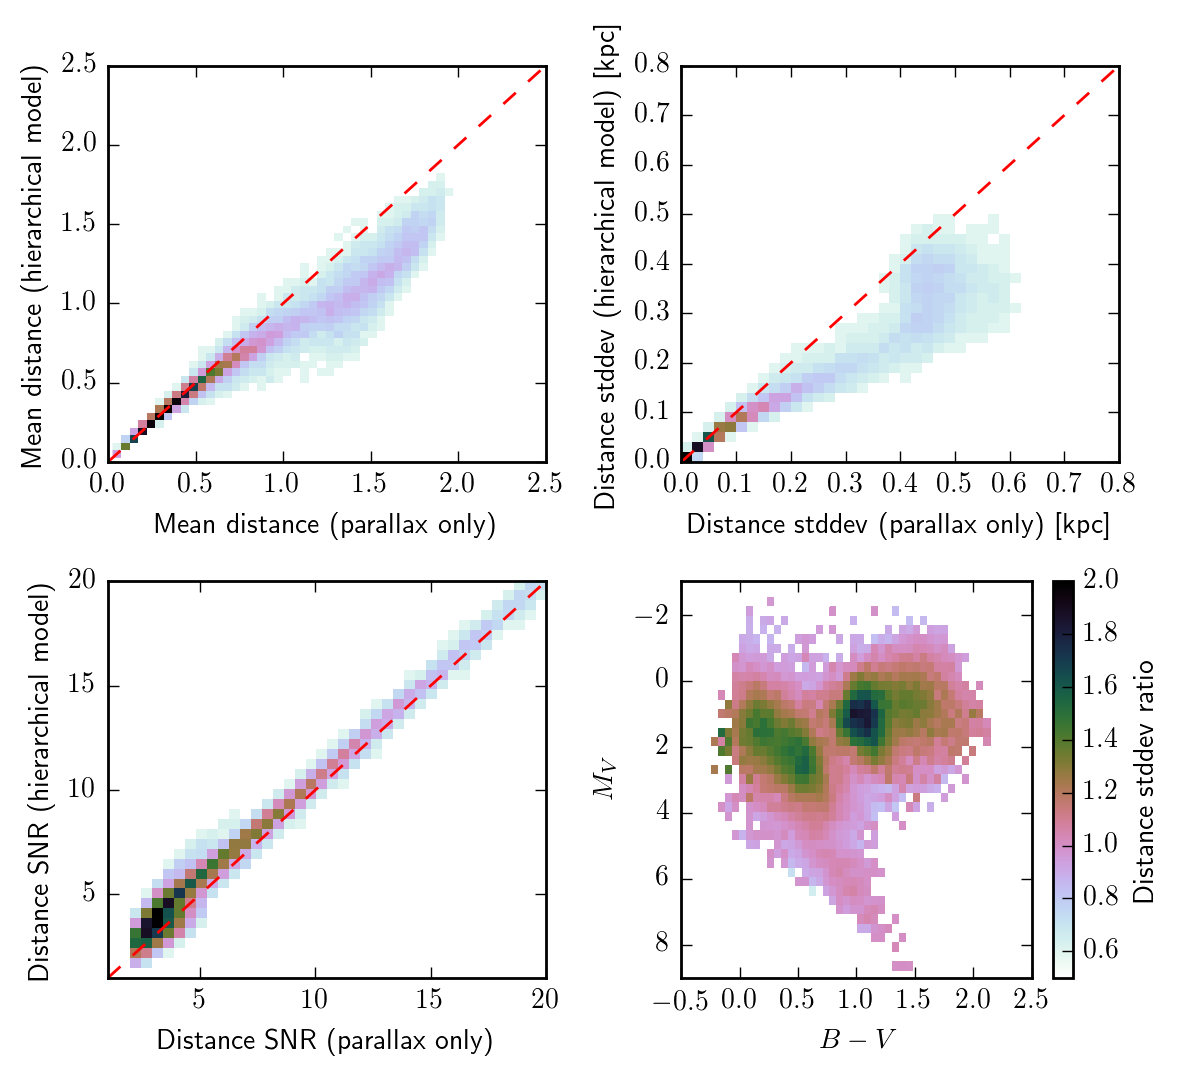

In [41]:
from copy import deepcopy

cmap = deepcopy(plt.cm.cubehelix_r)
cmap.set_gamma(0.5)
fig, axs = plt.subplots(2, 2, figsize=(6, 5.5))
axs = axs.ravel()

tnbins = 40
axs[0].hist2d(mean_vals1, mean_vals2, tnbins, cmap=cmap)
axs[0].plot([0, dist_max], [0, dist_max], c='r', ls='dashed')
axs[0].set_ylim([0, dist_max])
axs[0].set_xlim([0, dist_max])
axs[0].set_xlabel('Mean distance (parallax only)')
axs[0].set_ylabel('Mean distance (hierarchical model)')
ind = std_vals1 > 0
ind &= std_vals2 > 0
#rrr = -3
#axs[1].hist2d(np.log10(std_vals1[ind]), np.log10(std_vals2[ind]), tnbins, range=[[-4, 0], [-4, 0]], cmap=cmap)
#axs[1].plot([rrr, 0], [rrr, 0], c='r', ls='dashed')
#axs[1].set_ylim([rrr, 0])
#axs[1].set_xlim([rrr, 0])
rrr = 0.8
axs[1].hist2d(std_vals1[ind], std_vals2[ind], tnbins, range=[[0, rrr], [0, rrr]], cmap=cmap)
axs[1].plot([0, rrr], [0, rrr], c='r', ls='dashed')
axs[1].set_ylim([0, rrr])
axs[1].set_xlim([0, rrr])
axs[1].set_xlabel('Distance stddev (parallax only) [kpc]')
axs[1].set_ylabel('Distance stddev (hierarchical model) [kpc]')

rrr = 20
snr1 = mean_vals1 / std_vals1
snr2 = mean_vals2 / std_vals2
axs[2].plot([1, rrr], [1, rrr], c='r', ls='dashed')
axs[2].hist2d(snr1, snr2, tnbins, cmap=cmap, range=[[1, rrr], [1, rrr]])
axs[2].set_xlabel('Distance SNR (parallax only)')
axs[2].set_ylabel('Distance SNR (hierarchical model)')

cmap2 = deepcopy(plt.cm.cubehelix_r)
cmap2.set_gamma(1)

meanerrratio, xedges, yedges, binall = scipy.stats.binned_statistic_2d(
    obscolors[ind_training, 0], obsabsmag[ind_training], (std_vals1/std_vals2), bins=tnbins)
meanerrratio[~np.isfinite(meanerrratio)] = 0
vs = axs[3].pcolormesh(xedges, yedges, meanerrratio.T, cmap=cmap2, vmin=0.5, vmax=2, rasterized=True, lw=0)
clb = plt.colorbar(vs, ax=axs[-1])#.ravel().tolist())
clb.set_label('Distance stddev ratio')
axs[3].set_ylim(lines[0][-1], lines[0][0])
axs[3].set_xlim(lines[1][0], lines[1][-1])
axs[3].set_xlabel(r'$B-V$')
axs[3].set_ylabel(r'$M_V$')
fig.tight_layout()
fig.savefig('../paper/colmagdiag_mainsample_dist.pdf')

# Open Clusters

In [42]:
all_clusters = Table.read('/Users/bl/Dropbox/repos/Starlight/webdaclusters.csv')
all_names = np.array([x.replace(' ', '') for x in all_clusters['Cluster_name']])
ind = ~all_clusters['Dist'].mask
ind &= ~all_clusters['RA_2000'].mask
ind &= ~all_clusters['DEC_2000'].mask
ocs_dist = all_clusters['Dist'].data[ind].filled() # pc
ocs_ra = all_clusters['RA_2000'].data[ind].filled()
ocs_dec = all_clusters['DEC_2000'].data[ind].filled()
ocs_l = all_clusters['l'].data[ind].filled()
ocs_b = all_clusters['b'].data[ind].filled()
ocs_names = all_names[ind]
print(np.sum(ind), ocs_names)

1082 ['Collinder285' 'Melotte25' 'Chereul3' ..., 'BH176' 'Berkeley29' 'BH4']


In [43]:
ocs_coords = SkyCoord(ra=ocs_ra, dec=ocs_dec, frame='icrs', unit=(units.hourangle, units.deg))

In [44]:
nobj = len(df) #
sel = np.random.choice(len(df), nobj, replace=False)

varpi = df[['parallax']].values[sel, :].ravel().astype(np.double)
varpi_err = df[['parallax_error']].values[sel, :].ravel().astype(np.double)

ls = df[['l']].values[sel, :].ravel().astype(np.double)
bs = df[['b']].values[sel, :].ravel().astype(np.double)
distances = (1/varpi)
coords = SkyCoord(ls*units.deg, bs*units.deg, distance=distances*units.pc, frame='galactic')
ras, decs = coords.icrs.ra.rad, coords.icrs.dec.rad
ebv = bayestar(coords, mode='median')
ebv2 = sfd(coords)
ind2 = ~np.isfinite(ebv)
ebv[ind2] = 0 #ebv2[ind2]

B_RedCoeff = 3.626
V_RedCoeff = 2.742

obsmags = df[['vmag']].values[sel, :].astype(np.double).ravel() - ebv * V_RedCoeff
obsmags_err = df[['e_vmag']].values[sel, :].astype(np.double).ravel()

ncols = 1
obscolors = df[['bmag']].values[sel, :].astype(np.double) - ebv[:, None] * B_RedCoeff - obsmags[:, None]
obscolors_err = np.sqrt(df[['e_bmag']].values[sel, :].astype(np.double)**2 + obsmags_err[:, None]**2)

obsabsmag = obsmags + 5*np.log10(varpi) - 10
obsabsmagG = df[['phot_g_mean_mag']].values[sel, :].astype(np.double).ravel() + 5*np.log10(varpi) - 10
obsabsmag.min(), obsabsmag.max(), obscolors.min(), obscolors.max()

ind = np.abs(ebv) < 2
ind &= np.isfinite(ebv)
ind &= 1/varpi < dist_max
ind &= obsabsmag > lines[0].min()
ind &= obsabsmag < lines[0].max()
for i in range(ncols):
    ind &= obscolors[:, i] > lines[i+1].min()
    ind &= obscolors[:, i] < lines[i+1].max()
varpi = varpi[ind]
varpi_err = varpi_err[ind]
ras, decs = ras[ind], decs[ind]
obsmags = obsmags[ind]
obsmags_err = obsmags_err[ind]
obscolors = obscolors[ind, :]
obscolors_err = obscolors_err[ind, :]
obsabsmag = obsabsmag[ind]
nobj = ind.sum()
print(nobj)

/Users/bl/anaconda/lib/python3.5/site-packages/numpy/lib/function_base.py:3578: RuntimeWarning: Invalid value encountered in median for 472598 results
  RuntimeWarning)


1450540


In [45]:
from scipy import spatial
tree = spatial.KDTree(np.vstack((ras, decs)).T)

In [46]:
stop

NameError: name 'stop' is not defined

12 15 11 16 27 14 

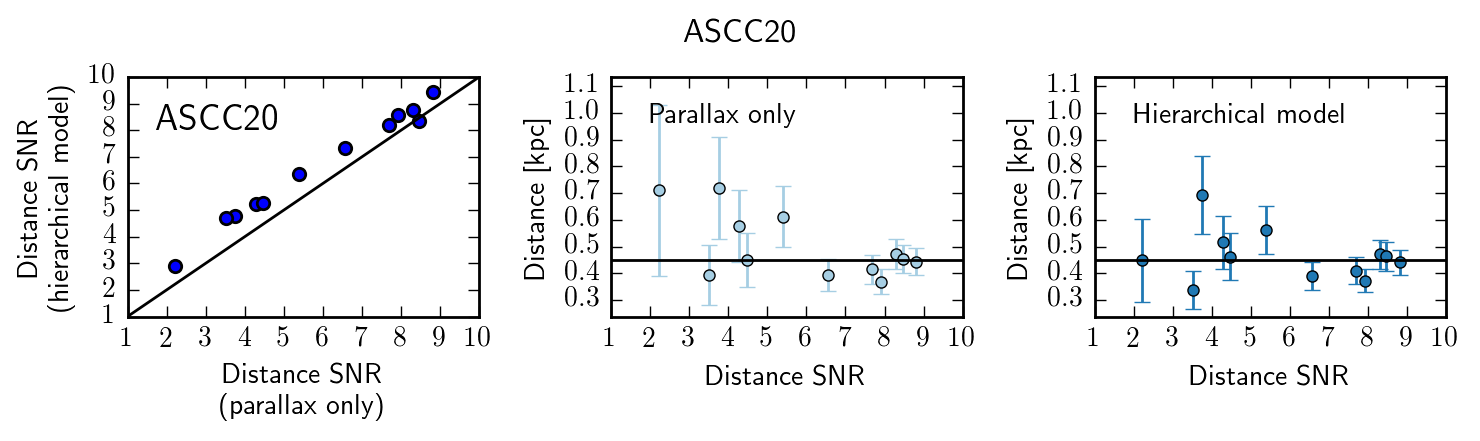

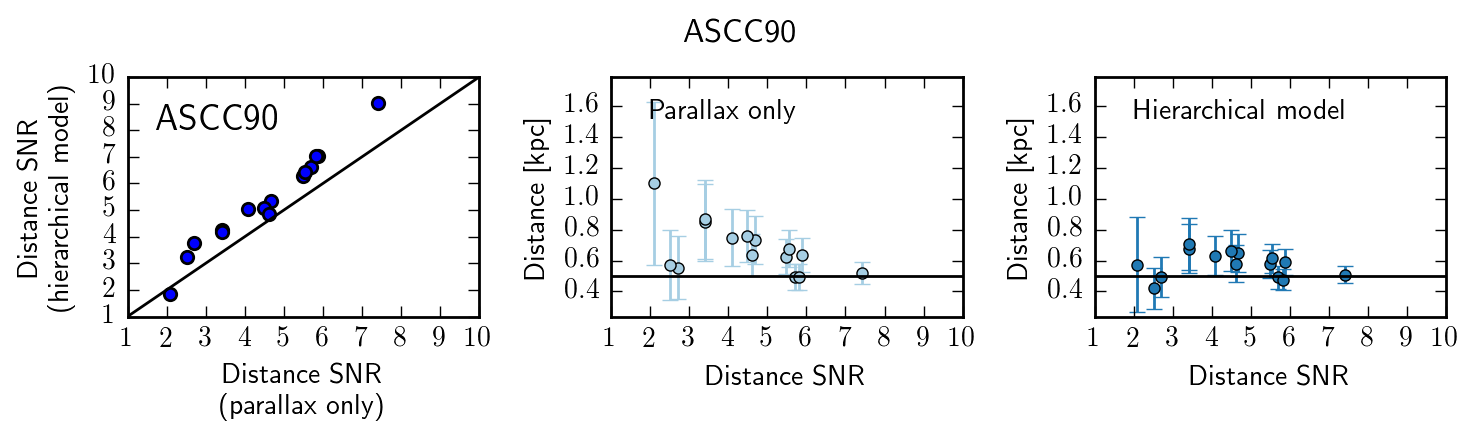

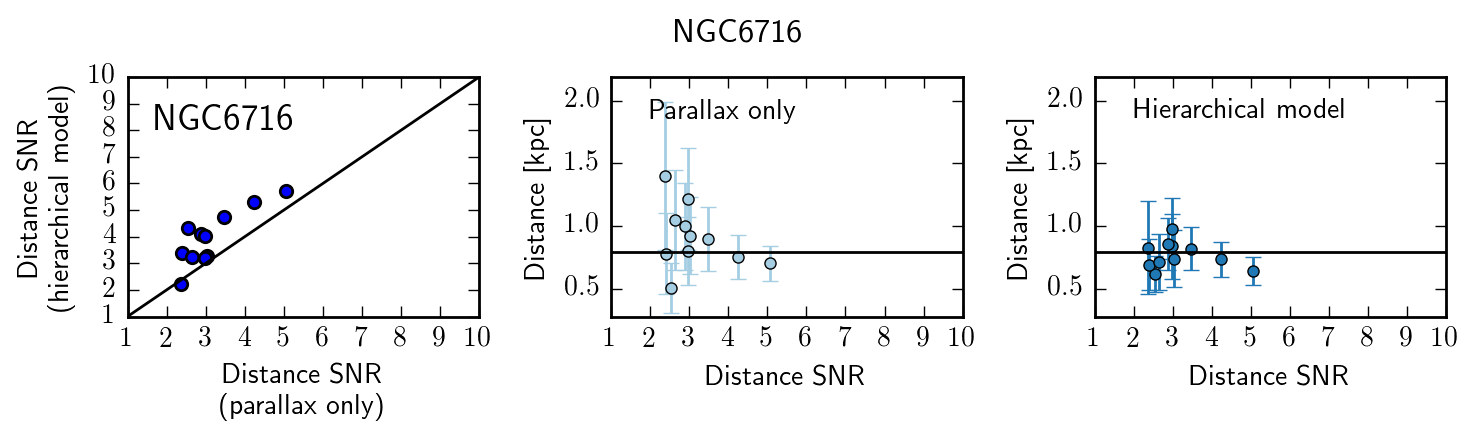

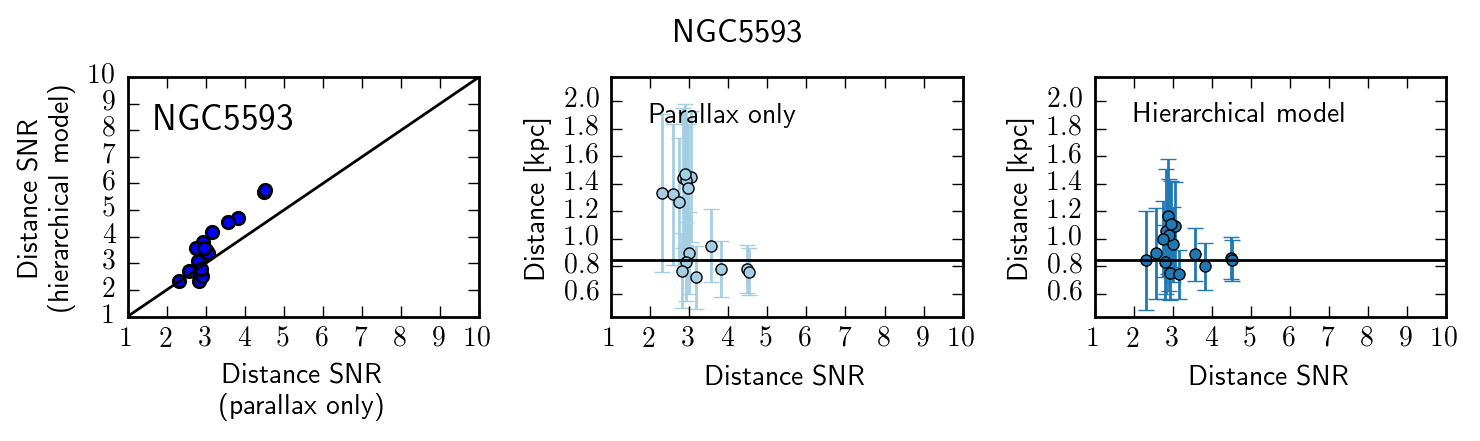

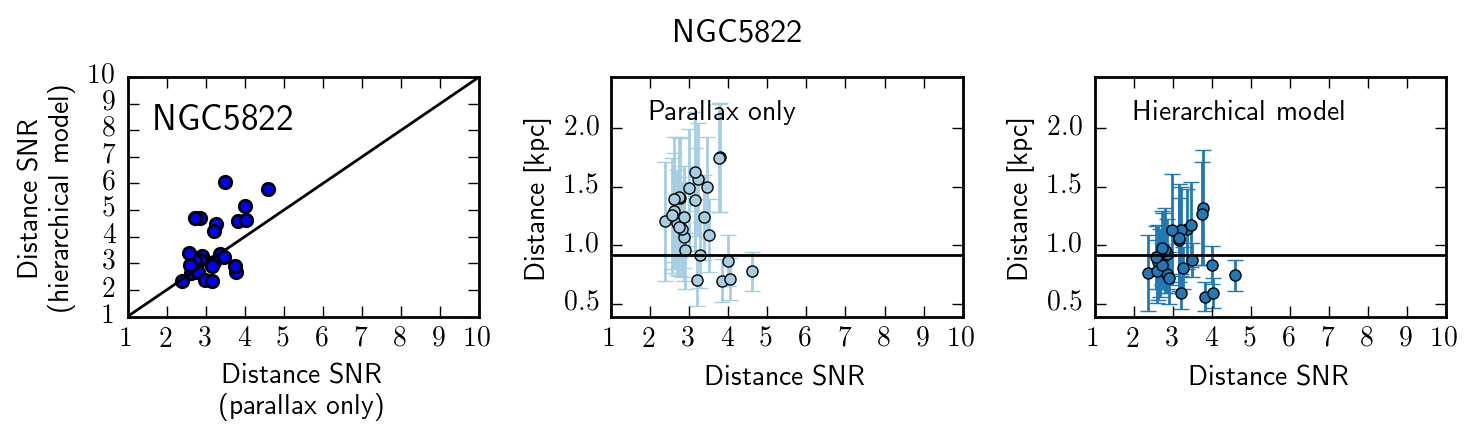

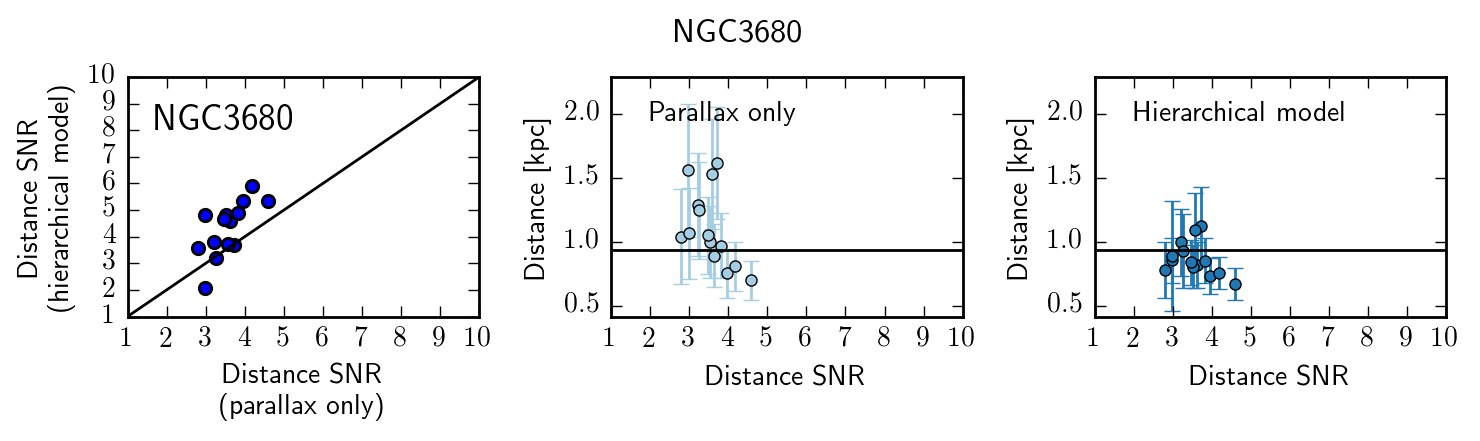

In [47]:
deg2rad = np.pi/180.0

for clname, oc_dist_pc, oc_ra, oc_dec in zip(ocs_names, ocs_dist, ocs_coords.ra.rad, ocs_coords.dec.rad):
    theta = np.arctan2(3.0, oc_dist_pc)
    oc_dist = oc_dist_pc / 1e3
    idx = np.array(tree.query_ball_point([oc_ra, oc_dec], theta))
    if idx.size > 1 and clname in ['NGC3680', 'NGC5822', 'NGC5593', 'ASCC90', 'ASCC20', 'NGC6716']:
        ind = np.abs(varpi[idx] - 1./oc_dist) < 2*varpi_err[idx]
        ind &= varpi[idx]/varpi_err[idx] < 10
        ind = np.where(ind)[0]
        print(ind.size, end=" ")
        if ind.size > 10:
            ind_cl = idx[ind]
            
            ndistg = 100
            fac = 6
            muds = 1./varpi[ind_cl]
            sigds = varpi_err[ind_cl]/varpi[ind_cl]**2
            dist_mins = muds - fac*sigds
            dist_mins[dist_mins < dist_min] = dist_min
            dist_maxs = muds + fac*sigds
            dist_maxs[dist_maxs > dist_max] = dist_max
            dist_deltas = (dist_maxs - dist_mins) / (ndistg - 1)
            distance_grids = dist_mins[:, None] + dist_deltas[:, None] * np.arange(ndistg)[None, :]

            probgrid_mean = np.zeros((ind_cl.size, ndistg))
            binamps_sel_val = binamps_samples.mean(axis=0)
            prob_distgrids_marg(
                            probgrid_mean, ndistg, distance_grids,
                            ind_cl.size, nbins_sel, ncols,
                            varpi[ind_cl], varpi_err[ind_cl],
                            obsmags[ind_cl], obsmags_err[ind_cl],
                            obscolors[ind_cl, :], obscolors_err[ind_cl, :],
                            binamps_sel_val, binmus_sel, binsigs_sel)

            probgrid_flat = np.zeros((ind_cl.size, ndistg))
            binamps_sel_val[:] = 1./nbins
            prob_distgrids_marg(
                            probgrid_flat, ndistg, distance_grids,
                            ind_cl.size, nbins_sel, ncols,
                            varpi[ind_cl], varpi_err[ind_cl],
                            obsmags[ind_cl], obsmags_err[ind_cl],
                            obscolors[ind_cl, :], obscolors_err[ind_cl, :],
                            binamps_sel_val, binmus_sel, binsigs_sel)
            mean_vals1 = np.zeros((ind_cl.size, ))
            std_vals1 = np.zeros((ind_cl.size, ))
            mean_vals2 = np.zeros((ind_cl.size, ))
            std_vals2 = np.zeros((ind_cl.size, ))
            for o in range(ind_cl.size):
                if probgrid_mean[o, :].sum() > 0:
                    mean_vals2[o] = np.average(distance_grids[o, :], weights=probgrid_mean[o, :])
                    std_vals2[o] = np.average((distance_grids[o, :] - mean_vals2[o])**2, weights=probgrid_mean[o, :])**0.5
                if probgrid_flat[o, :].sum() > 0:
                    mean_vals1[o] = np.average(distance_grids[o, :], weights=probgrid_flat[o, :])
                    std_vals1[o] = np.average((distance_grids[o, :] - mean_vals1[o])**2, weights=probgrid_flat[o, :])**0.5
    
            fig, axs = plt.subplots(1, 3, figsize=(7.5, 2.2))
            rr, s = 10, 4
            plt.suptitle(clname, fontsize=12)
            axs[0].scatter((mean_vals1-oc_dist), (mean_vals2-oc_dist))
            rrr = 0.39
            #axs[0].plot([-rrr, rrr], [-rrr, rrr], color='k')
            #axs[0].set_ylim([-rrr, rrr])
            #axs[0].set_xlim([-rrr, rrr])
            #axs[0].set_ylabel('Distance residual\n (hierarchical model)')
            #axs[0].set_xlabel('Distance residual\n (parallax only)')
            axs[0].text(1.7, 8, clname, fontsize=13)
            axs[0].scatter(mean_vals1/std_vals1, mean_vals2/std_vals2)
            axs[0].plot([0, rr], [0, rr], color='k')
            axs[0].set_xlim([1, rr])
            axs[0].set_ylim([1, rr])
            axs[0].set_ylabel('Distance SNR\n (hierarchical model)')
            axs[0].set_xlabel('Distance SNR\n (parallax only)')
            y1 = 0.9*np.min([mean_vals1 - std_vals1, mean_vals2 - std_vals2])
            y2 = 1.1*np.max([mean_vals1 + std_vals1, mean_vals2 + std_vals2])
            axs[1].errorbar(mean_vals1/std_vals1, mean_vals1, yerr=std_vals1, fmt="o", markersize=s, color=cols[0])
            axs[1].axhline(oc_dist, color='k')
            axs[1].set_xlabel('Distance SNR')
            axs[1].set_ylabel('Distance [kpc]')
            axs[1].text(2, 0.85*y2, 'Parallax only')
            axs[1].set_ylim([y1, y2])
            axs[1].set_xlim([1, rr])
            axs[2].errorbar(mean_vals1/std_vals1, mean_vals2, yerr=std_vals2, fmt="o", markersize=s, color=cols[1])
            axs[2].axhline(oc_dist, color='k')
            axs[2].set_xlabel('Distance SNR')
            axs[2].set_ylabel('Distance [kpc]')
            axs[2].text(2, 0.85*y2, 'Hierarchical model')
            axs[2].set_ylim([y1, y2])
            axs[2].set_xlim([1, rr])
            fig.tight_layout()
            fig.subplots_adjust(top=0.85)
            fig.savefig('../paper/'+clname+'_metrics.pdf')
            #stop

In [ ]:
stop

In [ ]:
def func(x, a, b, mu, sig):
    yb = np.exp(x)**-b * skewnorm.pdf((x-mu)/sig, a)
    return yb / np.trapz(yb, x)

fig, axs = plt.subplots(4, 4, figsize=(8, 5))
axs = axs.ravel()
for i in range(0, len(axs)):
    if probgrid_flat[i, :].max() > 0:#1e-200:
        #y = probgrid_flat[i, :] / np.trapz(probgrid_flat[i, :], x=distance_grids[i, :])
        y = probgrid_mean[i, :] / np.trapz(probgrid_mean[i, :], x=distance_grids[i, :])
        #print(mean_vals1[i], std_vals1[i], varpi[ind_training[i]], varpi_err[ind_training[i]])
        p0 = [10, 1, mean_vals1[i], std_vals1[i]]
        popt, pcov = curve_fit(func, distance_grids[i, :], y, p0=p0)
        #print(popt)
        #y2 = func(distances_grid, *p0)
        y2 = func(distance_grids[i, :], *popt)

        axs[i].plot(distance_grids[i, :], y, c='k')
        axs[i].plot(distance_grids[i, :], 0*y, c='k')
        axs[i].plot(distance_grids[i, :], y2, c='r')
        axs[i].plot(distance_grids[i, :], y2-y, c='b')
        #print(np.sum(y-y2))
fig.tight_layout()

In [ ]:
stop

In [ ]:
params_flat = np.zeros((ind_training.size, 5))
params_mean = np.zeros((ind_training.size, 5))
ind_failed = []
for i in range(ind_training.size):
    y1 = probgrid_flat[i, :] / np.trapz(probgrid_flat[i, :], distance_grids[i, :])
    y2 = probgrid_mean[i, :] / np.trapz(probgrid_mean[i, :], distance_grids[i, :])
    p01 = [10, 1, mean_vals1[i], std_vals1[i]]
    p02 = [10, 1, mean_vals2[i], std_vals2[i]]
    try:
        popt1, pcov2 = curve_fit(func, distance_grids[i, :], y1, p0=p01)
        popt2, pcov2 = curve_fit(func, distance_grids[i, :], y2, p0=p02)
        params_flat[i, 0:-1] = popt1
        yb = func(distance_grids[i, :], *popt1)
        params_mean[i, 0:-1] = popt2
        yb = func(distance_grids[i, :], *popt2)
        params_flat[i, -1] = np.max(np.abs(y1-yb))
        params_mean[i, -1] = np.max(np.abs(y2-yb))
    except:
        print(i, end=" ")
        ind_failed.append(i)
        #plt.plot(distance_grids[i, :], y1)
        #plt.plot(distance_grids[i, :], y2)
        #stop

In [ ]:
len(ind_failed), ind_training.size

In [ ]:
stop

In [ ]:
# noisyfying parallaxes of validation sample
varpi_err_val = varpi_err[ind_validation]
varpi_val = varpi[ind_validation]
extra_varpi_err_val = varpi_err_val * 5
varpi_val += extra_varpi_err_val * np.random.randn(ind_validation.size)
varpi_err_val = np.sqrt(varpi_err_val**2 + extra_varpi_err_val**2)

In [ ]:
ndistg = 50
fac = 5
muds = 1./varpi_val
sigds = varpi_err_val/varpi_val**2
dist_mins = muds - fac*sigds
dist_mins[dist_mins < dist_min] = dist_min
dist_maxs = muds + fac*sigds
dist_maxs[dist_maxs > dist_max] = dist_max
dist_deltas = (dist_maxs - dist_mins) / (ndistg - 1)
distance_grids = dist_mins[:, None] + dist_deltas[:, None] * np.arange(ndistg)[None, :]

In [ ]:
# shrinkage of distances in validation set
probgrid_mean = np.zeros((ind_validation.size, ndistg))
binamps_sel_val = binamps_samples.mean(axis=0)
prob_distgrids_marg(
                probgrid_mean, ndistg, distance_grids,
                ind_validation.size, nbins_sel, ncols,
                varpi_val, varpi_err_val,
                obsmags[ind_validation], obsmags_err[ind_validation],
                obscolors[ind_validation, :], obscolors_err[ind_validation, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

probgrid_flat = np.zeros((ind_validation.size, ndistg))
binamps_sel_val[:] = 1./nbins
prob_distgrids_marg(
                probgrid_flat, ndistg, distance_grids,
                ind_validation.size, nbins_sel, ncols,
                varpi_val, varpi_err_val,
                obsmags[ind_validation], obsmags_err[ind_validation],
                obscolors[ind_validation, :], obscolors_err[ind_validation, :],
                binamps_sel_val, binmus_sel, binsigs_sel)
mean_vals1 = np.zeros((ind_validation.size, ))
std_vals1 = np.zeros((ind_validation.size, ))
mean_vals2 = np.zeros((ind_validation.size, ))
std_vals2 = np.zeros((ind_validation.size, ))
for o in range(ind_validation.size):
    mean_vals2[o] = np.average(distance_grids[o, :], weights=probgrid_mean[o, :])
    mean_vals1[o] = np.average(distance_grids[o, :], weights=probgrid_flat[o, :])
    std_vals1[o] = np.average((distance_grids[o, :] - mean_vals1[o])**2, weights=probgrid_flat[o, :])**0.5
    std_vals2[o] = np.average((distance_grids[o, :] - mean_vals2[o])**2, weights=probgrid_mean[o, :])**0.5

In [ ]:
fig, axs = plt.subplots(5, 4, figsize=(10, 6), sharex=True, sharey=True)
#for i in range(axs.shape[0]):
    #axs[i, 0].set_ylabel('Posterior distribution')
for i in range(axs.shape[1]):
    axs[-1, i].set_xlabel('Distance [kpc]')
axs = axs.ravel()
dist_val = 1/varpi[ind_validation]
dist_err_val = varpi_err[ind_validation] / varpi[ind_validation]**2
ind3 = varpi_val > 0
ind3 &= dist_err_val < 0.05
js = np.random.choice(np.where(ind3)[0], axs.size, replace=False)#
for i in range(axs.size):
    #axs[i].axvspan(dist_val[js[i]]-dist_err_val[js[i]], dist_val[js[i]]+dist_err_val[js[i]],  color='gray', alpha=0.5)
    axs[i].axvline(dist_val[js[i]], color='k', label='truth', lw=2)
    y = probgrid_flat[js[i], :]/np.max(probgrid_flat[js[i], :])
    #ind = y > 0.01
    axs[i].plot(distance_grids[i, :], y[:], c=cols[0], lw=2, label='parallax only')
    y = probgrid_mean[js[i], :]/np.max(probgrid_mean[js[i], :])
    #ind = y > 0.01
    axs[i].plot(distance_grids[i, :], y[:], c=cols[1], lw=2, label='hierarchical model')
    axs[i].set_yticks([])
    axs[i].set_ylim([0, 1.1])
    axs[i].text(1.5, 0.2, 'SNR = %.2f' % (varpi_val[js[i]]/varpi_err_val[js[i]]))
axs[0].legend(ncol=3, frameon=False, loc='upper left', bbox_to_anchor=(0.0, 1.45))
fig.tight_layout()
fig.subplots_adjust(top=0.95)
fig.savefig('../paper/cv_noisified_pdfs.pdf')

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))
ind = dist_err_val > 0#.1
rr = 2
axs[0].errorbar(dist_val[ind], mean_vals1[ind], yerr=std_vals1[ind], fmt='o', markersize=1, alpha=0.1)
axs[1].errorbar(dist_val[ind], mean_vals2[ind], yerr=std_vals2[ind], fmt='o', markersize=1, alpha=0.1)
axs[0].plot([0, rr], [0, rr], c='k')
axs[1].plot([0, rr], [0, rr], c='k')
axs[0].set_xlim([0, rr])
axs[0].set_ylim([0, rr])
axs[1].set_xlim([0, rr])
axs[1].set_ylim([0, rr])

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(10, 3))
axs[0].hist(mean_vals1-dist_val, histtype='step', color='r', ls='--')
axs[0].hist(mean_vals2-dist_val, histtype='step', color='b')
axs[0].axvline(0, c='k')
axs[1].hist(std_vals1, histtype='step', color='r', ls='--')
axs[1].hist(std_vals2, histtype='step', color='b')
chi1s = (mean_vals1 - dist_val)**2 / std_vals1
chi2s = (mean_vals2 - dist_val)**2 / std_vals2
rr = 4
from scipy.stats import chi2
x = np.linspace(0, rr, 100)
axs[2].hist(chi1s, 50, histtype='step', color='r', ls='--', range=[0, rr], normed=True)
axs[2].hist(chi2s, 50, histtype='step', color='b', range=[0, rr], normed=True)
axs[2].plot(x, chi2.pdf(x, 1), c='k')
axs[2].set_xlim([0, rr])
axs[2].set_yscale('log')
fig.tight_layout()

In [ ]:
cmap = plt.cm.cubehelix_r
cmap.set_gamma(0.5)
fig, axs = plt.subplots(1, 3, figsize=(7.2, 2.2))
axs = axs.ravel()
tnbins = 20
axs[0].hist2d(mean_vals1, mean_vals2, tnbins, cmap=cmap)
axs[0].plot([0, dist_max], [0, dist_max], c='r', ls='dashed')
axs[0].set_ylim([0, dist_max])
axs[0].set_xlim([0, dist_max])
axs[0].set_xlabel('Mean distance (parallax only) [kpc]')
axs[0].set_ylabel('Mean distance\n (hierarchical model) [kpc]')
ind = std_vals1 > 0
ind &= std_vals2 > 0
rrr = -2
axs[1].hist2d(np.log10(std_vals1[ind]), np.log10(std_vals2[ind]), tnbins, range=[[rrr, 0], [rrr, 0]], cmap=cmap)
axs[1].plot([rrr, 0], [rrr, 0], c='r', ls='dashed')
axs[1].set_ylim([rrr, 0])
axs[1].set_xlim([rrr, 0])
axs[1].set_xlabel('Log dist stddev (parallax only) [log kpc]')
axs[1].set_ylabel('Log dist stddev\n (hierarchical model) [log kpc]')

axs[2].hist(mean_vals1-dist_val, histtype='step', color=cols[0], lw=2, label='Parallax only')
counts, e, _ = axs[2].hist(mean_vals2-dist_val, histtype='step', color=cols[1], lw=2, label='Hierarchical model')
#axs[2].axvline(0, c='k')
axs[2].legend(loc='upper right', frameon=False, fontsize=8)
axs[2].set_ylim([0, 1.5*np.max(counts)])
axs[2].set_xlim([-1.2, 1.2])
axs[2].set_xlabel('Scaled distance residual')
axs[2].set_ylabel('$N_\mathrm{stars}$')

fig.tight_layout()
fig.savefig('../paper/cv_metrics.pdf')

In [ ]:
ratio = std_vals1[std_vals2 > 0]/std_vals2[std_vals2 > 0]
print(np.percentile(ratio, [5, 50, 95]))
print((std_vals1/std_vals2 > 2).sum() / std_vals1.size)

In [ ]:
stop

In [ ]:
clname = 'Praesepe' #     'Pleiades' #'Blanco1'  # 'NGC6475' # 
fname = '../cluster_sources/'+clname+'-tgas-apassdr9-members.csv'
data = Table.read(fname).to_pandas()
data.columns

In [ ]:
varpi = data[['parallax']].values.ravel().astype(np.double)
varpi_err = data[['parallax_error']].values.ravel().astype(np.double)
varpi_err = np.sqrt(varpi_err**2 + 0.3**2)

obsmags = data[['vjmag']].values.astype(np.double).ravel()
obsmags_err = data[['evjmag']].values.astype(np.double).ravel()

ncols = 1
obscolors = data[['bjmag']].values.astype(np.double) - obsmags[:, None]
obscolors_err = np.sqrt(data[['ebjmag']].values.astype(np.double)**2 + obsmags_err[:, None]**2)

oc_dist = data[['OC_dist']].values.astype(np.double).ravel()

In [ ]:
distances_grid = np.linspace(0.001, 1.0, 300)
nobj = len(data)
probgrid_mean = np.zeros((nobj, distances_grid.size))
binamps_sel_val = binamps_samples.mean(axis=0)

prob_distgrid_marg(
                probgrid_mean, distances_grid.size, distances_grid,
                nobj, nbins_sel, ncols,
                varpi[:], varpi_err[:],
                obsmags[:], obsmags_err[:],
                obscolors[:, :], obscolors_err[:, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

probgrid_flat = np.zeros((ind_training_worst.size, distances_grid.size))
binamps_sel_val[:] = 1./nbins
prob_distgrid_marg(
                probgrid_flat, distances_grid.size, distances_grid,
                nobj, nbins_sel, ncols,
                varpi[:], varpi_err[:],
                obsmags[:], obsmags_err[:],
                obscolors[:, :], obscolors_err[:, :],
                binamps_sel_val, binmus_sel, binsigs_sel)

In [ ]:
fig, axs = plt.subplots(6, 5, figsize=(10, 8), sharex=False, sharey=True)
axs = axs.ravel()
for i in range(axs.size):
    y = probgrid_mean[i, :]/np.max(probgrid_mean[i, :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c='b', lw=2)
    y = probgrid_flat[i, :]/np.max(probgrid_flat[i, :])
    ind = y > 0.01
    axs[i].plot(distances_grid[ind], y[ind], c='r', lw=2, ls='--')
    axs[i].set_yticks([])
    axs[i].axvline(oc_dist[i], color='k')
fig.tight_layout()

In [ ]:
mean_vals1 = np.zeros((nobj, ))
std_vals1 = np.zeros((nobj, ))
mean_vals2 = np.zeros((nobj, ))
std_vals2 = np.zeros((nobj, ))
for o in range(nobj):
    if probgrid_mean[o, :].sum() > 0 and probgrid_flat[o, :].sum() > 0:
        mean_vals2[o] = np.average(distances_grid, weights=probgrid_mean[o, :])
        mean_vals1[o] = np.average(distances_grid, weights=probgrid_flat[o, :])
        std_vals1[o] = np.average((distances_grid - mean_vals1[o])**2, weights=probgrid_flat[o, :])**0.5
        std_vals2[o] = np.average((distances_grid - mean_vals2[o])**2, weights=probgrid_mean[o, :])**0.5

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(8, 2.2))
rr = 15
s = 5

plt.suptitle(clname, fontsize=12)

axs[0].scatter((mean_vals1-oc_dist[0]), (mean_vals2-oc_dist[0]))
rrr = 0.09
axs[0].plot([-rrr, rrr], [-rrr, rrr], color='k')
axs[0].set_ylim([-rrr, rrr])
axs[0].set_xlim([-rrr, rrr])
axs[0].set_ylabel('Distance residual\n (hierarchical model)')
axs[0].set_xlabel('Distance residual\n (parallax only)')

axs[1].scatter(mean_vals1/std_vals1,
              mean_vals2/std_vals2)
axs[1].plot([0, rr], [0, rr], color='k')
axs[1].set_xlim([1, rr])
axs[1].set_ylim([1, rr])
axs[1].set_ylabel('Distance SNR\n (hierarchical model)')
axs[1].set_xlabel('Distance SNR\n (parallax only)')

y1 = 0.9*np.min([mean_vals1 - std_vals1, mean_vals2 - std_vals2])
y2 = 1.1*np.max([mean_vals1 + std_vals1, mean_vals2 + std_vals2])

axs[2].errorbar(mean_vals1/std_vals1, mean_vals1, yerr=std_vals1, fmt="o", markersize=s, color=cols[0])
axs[2].axhline(oc_dist[0], color='k')
axs[2].set_xlabel('Distance SNR')
axs[2].set_ylabel('Distance')
axs[2].text(3, 0.9*y2, 'Parallax only')
axs[2].set_ylim([y1, y2])
axs[2].set_xlim([1, rr])

axs[3].errorbar(mean_vals1/std_vals1, mean_vals2, yerr=std_vals2, fmt="o", markersize=s, color=cols[1])
axs[3].axhline(oc_dist[0], color='k')
axs[3].set_xlabel('Distance SNR')
axs[3].set_ylabel('Distance')
axs[3].text(2.3, 0.9*y2, 'Hierarchical model')
axs[3].set_ylim([y1, y2])
axs[3].set_xlim([1, rr])
                  
fig.tight_layout()
fig.subplots_adjust(top=0.85)
fig.savefig('../paper/'+clname+'_metrics.pdf')

In [ ]:
plt.pcolormesh(fgrids[1], fgrids[0], inf_model, cmap=cmap)
plt.scatter(obscolors, obsmags + 5*np.log10(varpi) - 10)
plt.ylim(lines[0][-1], lines[0][0])
plt.xlim(lines[1][-1], lines[1][0])